In [1]:
import tracemalloc
import pickle
from cov_3X2 import *
from lsst_utils import *
from scipy.stats import norm,mode,skew,kurtosis,percentileofscore
import seaborn as sns
colors=sns.color_palette()
markers=['o','s','^','>','v']

/usr/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
import lsst_utils
import cov_3X2
import tracer_utils
import window_utils
import importlib
reload=importlib.reload
reload(lsst_utils)
reload(window_utils)
reload(tracer_utils)
reload(cov_3X2)
from lsst_utils import *
from cov_3X2 import *

In [3]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [4]:
fig_home='./figures/'

In [5]:
from distributed import LocalCluster
from dask.distributed import Client  # we already had this above
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
worker_kwargs={'memory_spill_fraction':.75,'memory_target_fraction':.99,'memory_pause_fraction':1}
LC=LocalCluster(n_workers=1,processes=False,memory_limit='60gb',threads_per_worker=10,
                local_dir='/home/deep/repos/cosmic_shear/temp/NGL-worker/',
               **worker_kwargs,
                #scheduler_port=12234,
#                 dashboard_address=8801
                diagnostics_port=8801,
#                memory_monitor_interval='2000ms')
               )
client=Client(LC,diagnostics_port=8801,)

#LC.close()
#client.close()

In [6]:
client

Client Scheduler: inproc://136.152.250.206/8595/1 Dashboard: http://localhost:8801/status,Cluster Workers: 1 Cores: 10 Memory: 60.00 GB


In [7]:
nside=1024
l0w=np.arange(3*nside-1)

In [8]:
#setup parameters
# lmax_cl=1000
lmax_cl=int(nside*2.9)
lmin_cl=0
l0=np.arange(lmin_cl,lmax_cl)

lmin_cl_Bins=lmin_cl+10
lmax_cl_Bins=lmax_cl-10
Nl_bins=40
l_bins=np.int64(np.logspace(np.log10(lmin_cl_Bins),np.log10(lmax_cl_Bins),Nl_bins))
# l_bins=np.int64(np.linspace(lmin_cl_Bins,lmax_cl_Bins,Nl_bins))
lb=(l_bins[1:]+l_bins[:-1])*.5

l=l0 #np.unique(np.int64(np.logspace(np.log10(lmin_cl),np.log10(lmax_cl),Nl_bins*20))) #if we want to use fewer ell

do_cov=True
bin_cl=True

SSV_cov=False
tidal_SSV_cov=False

do_xi=False

In [9]:
use_shot_noise=True

In [10]:
use_window=True
f_sky=0.3
n_source_bins=1
sigma_gamma=0.3944/sqrt(2.)  #*2**0.25

In [11]:
store_win=True
unit_window=False
smooth_window=True

In [12]:
w_smooth_lmax=1.e7 #some large number
if smooth_window:
    w_smooth_lmax=1000
window_cl_fact=np.cos(np.pi/2*(l0w/w_smooth_lmax)**10)
x=window_cl_fact<0
x+=l0w>w_smooth_lmax
window_cl_fact[x]=0
if unit_window:
    window_cl_fact=0

In [13]:
corr_ggl=('galaxy','shear')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')

In [14]:
do_cov=True
store_win=True

In [15]:
wigner_files={}
wigner_files[0]= 'temp/dask_wig3j_l6500_w2100_0_reorder.zarr'
wigner_files[2]= 'temp/dask_wig3j_l3500_w2100_2_reorder.zarr'



In [16]:
corrs=[corr_ll,corr_ggl,corr_gg]
window_lmax=1500  #0.5 % difference between 100 and 400, for unit window, 2% for realistic window

In [17]:
th_min=1./60
th_max=600./60
n_th_bins=20
th_bins=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins+1)
th=np.logspace(np.log10(th_min*0.98),np.log10(1),n_th_bins*30)
th2=np.linspace(1,th_max*1.02,n_th_bins*30)
# th2=np.logspace(np.log10(1),np.log10(th_max),60*6)
th=np.unique(np.sort(np.append(th,th2)))
thb=np.sqrt(th_bins[1:]*th_bins[:-1])

bin_xi=True

# HT_kwargs={'l_min':l_min,  'l_max':l_max,
#                         'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
#                         'n_zeros':40000, 'prune_theta':prune_theta, 'm1_m2':[(2,2),(2,-2),(0,2),(0,0)]}
l0_win=np.arange(lmax_cl)
WT_L_kwargs={'l': l0_win,'theta': th*d2r,'m1_m2':[(2,2),(2,-2),(0,2),(2,0),(0,0)]}
WT_L=None
if do_xi:
    %time WT_L=wigner_transform(**WT_L_kwargs)

(0.001, 1000.0)

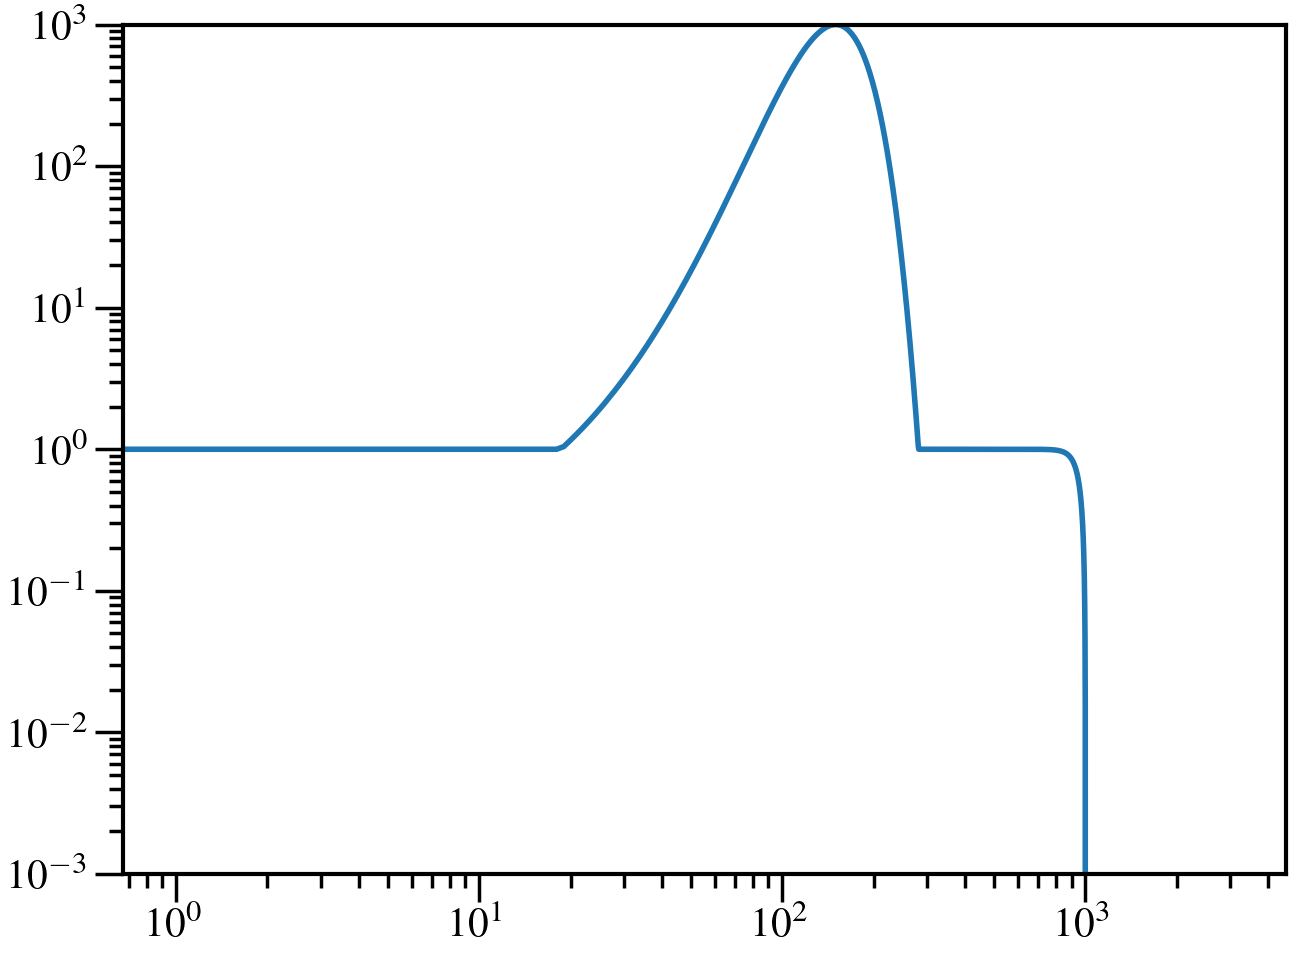

In [18]:
# l0w=np.arange(512)+1
mean=150
sigma=50
ww=1000*np.exp(-(l0w-mean)**2/sigma**2)
x=ww<1
ww[x]=1
# x=l0w>mean+3*sigma
# ww[x]=ww[l0w==mean+3*sigma]
loglog(l0w,ww*window_cl_fact)
ylim(1.e-3,1e3)

In [ ]:
z0=0.5
zl_bin1=lsst_source_tomo_bins(zp=np.array([z0]),p_zp=np.array([1]),ns=10,use_window=use_window,nbins=1,window_cl_fact=window_cl_fact,
                         f_sky=f_sky,nside=nside,unit_win=True,use_shot_noise=True)
zl_bin1w=lsst_source_tomo_bins(zp=np.array([z0]),p_zp=np.array([1]),ns=30,use_window=use_window,window_cl_fact=window_cl_fact*(1+ww),
                              f_sky=f_sky,nbins=n_source_bins,nside=nside,use_shot_noise=True)

ns0:  27.0
corr_indxs {('shear', 'shear'): [], ('galaxy', 'galaxy'): [(0, 0)], ('kappa', 'kappa'): []}
Win gen: step size 3072


./cov_utils.py:60: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th
./angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide
  self.cl_f=(l+0.5)**2/(l*(l+1.)) # cl correction from Kilbinger+ 2017
/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


cl dict done
ns0:  27.0
corr_indxs {('shear', 'shear'): [], ('galaxy', 'galaxy'): [(0, 0)], ('kappa', 'kappa'): []}
Win gen: step size 3072
cl dict done


/usr/lib/python3.7/site-packages/healpy/sphtfunc.py:402: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [ ]:
z0=1 #1087
zs_bin1=lsst_source_tomo_bins(zp=np.array([z0]),p_zp=np.array([1]),ns=30,use_window=use_window,window_cl_fact=window_cl_fact,
                              f_sky=f_sky,nbins=n_source_bins,nside=nside,unit_win=False,use_shot_noise=True)

zs_bin1w=lsst_source_tomo_bins(zp=np.array([z0]),p_zp=np.array([1]),ns=30,use_window=use_window,window_cl_fact=(1+ww)*window_cl_fact,
                              f_sky=f_sky,nbins=n_source_bins,nside=nside,use_shot_noise=True)

In [ ]:
hp.mollview(zs_bin1[0]['window'],title='window')
hp.mollview(zl_bin1[0]['window'],title='window')
hp.mollview(zs_bin1w[0]['window'],title='window')
hp.mollview(zl_bin1w[0]['window'],title='window')
# hp.mollview(win_tt,title='window')

In [ ]:
import window_utils
reload(window_utils)
from window_utils import *

import tracer_utils
reload(tracer_utils)
from tracer_utils import *


import cov_3X2
reload(cov_3X2)
from cov_3X2 import *

In [ ]:
client

In [ ]:
tracemalloc.clear_traces()
tracemalloc.start()


t1=time.time()
kappa_win=cov_3X2(zs_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=zl_bin1,
            use_window=use_window,store_win=store_win,window_lmax=window_lmax,corrs=corrs,
            SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
            HT=WT_L,bin_xi=bin_xi,theta_bins=th_bins,do_xi=do_xi,
                  wigner_files=wigner_files
                 #Win=kappa_win.Win.Win
                 )

t2=time.time()
print('W done',t2-t1)
%time clG_win=kappa_win.cl_tomo(corrs=corrs) 
%time cl0_win=clG_win['stack'].compute()

if do_xi:
    %time xiWG_L=kappa_win.xi_tomo()
    %time xiW_L=xiWG_L['stack'].compute()

In [ ]:
snapshot1 = tracemalloc.take_snapshot()

In [ ]:
top_stats = snapshot1.statistics('lineno')
top_stats

In [ ]:
stat = top_stats[3]
print("%s memory blocks: %.1f MiB" % (stat.count, stat.size / 1024**2))
for line in stat.traceback.format():
    print(line)

In [ ]:
l=kappa_win.window_l
Om_W=np.pi*4*f_sky
theta_win=np.sqrt(Om_W/np.pi)
l_th=l*theta_win
Win0=2*jn(1,l_th)/l_th
Win0=np.nan_to_num(Win0)

In [ ]:
kappa_win.z_bins.keys()

In [ ]:
bi=(0,0)

In [ ]:
R=kappa_win.Win.Win['cl'][corr_gg][bi]['M']/kappa_win.Win.Win['cl'][corr_ll][bi]['M']
R=np.nan_to_num(R)
x=R>0
R[x].max()

In [ ]:
kappa_win_w=cov_3X2(zs_bins=zs_bin1w,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=zl_bin1w,
            use_window=use_window,store_win=store_win,window_lmax=window_lmax,corrs=corrs,
            SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
            HT=WT_L,bin_xi=bin_xi,theta_bins=th_bins,do_xi=do_xi,
                    wigner_files=wigner_files
                   #Win=kappa_win_w.Win.Win
                   )

%time clG_win_w=kappa_win_w.cl_tomo(corrs=corrs) 
%time cl0_win_w=clG_win_w['stack'].compute()

if do_xi:
    %time xiWG_L_w=kappa_win_w.xi_tomo()
    %time xiW_L_w=xiWG_L_w['stack'].compute()

In [ ]:
kappa0=cov_3X2(zs_bins=zs_bin1,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=zl_bin1,
            use_window=False,store_win=store_win,corrs=corrs,
            SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
            HT=WT_L,bin_xi=bin_xi,theta_bins=th_bins,do_xi=do_xi)

%time clG0=kappa0.cl_tomo(corrs=corrs) 
%time cl0=clG0['stack'].compute()

if do_xi:
    %time xiG_L0=kappa0.xi_tomo()
    %time xi_L0=xiG_L0['stack'].compute()

In [ ]:
zl_bin1[0]['lm']

In [ ]:
bi=(0,0)
cl0={'cl_b':{},'cov':{},'cl':{}}
cl0_win_w={'cl_b':{},'cov':{}}
cl0_win={'cl_b':{},'cov':{}}
for corr in corrs:
    cl0['cl_b'][corr]=clG0['cl_b'][corr][bi].compute()
    cl0['cl'][corr]=clG0['cl'][corr][bi].compute()
    cl0['cov'][corr]=clG0['cov'][corr+corr][bi+bi].compute()
    
    cl0_win['cl_b'][corr]=clG_win['cl_b'][corr][bi].compute()
    cl0_win['cov'][corr]=clG_win['cov'][corr+corr][bi+bi].compute()['final_b']
    
    cl0_win_w['cl_b'][corr]=clG_win_w['cl_b'][corr][bi].compute()
    cl0_win_w['cov'][corr]=clG_win_w['cov'][corr+corr][bi+bi].compute()['final_b']

In [ ]:
import binning
reload(binning)
from binning import *
M_binnings={}
M_binning_utils={}
Mw_binning_utils={}
for corr in corrs:
    M_binnings[corr]=binning()
    wt_b=1./cl0['cl_b'][corr]
    wt0=cl0['cl'][corr]
    M_binning_utils[corr]=M_binnings[corr].bin_utils(r=kappa0.l,r_bins=kappa0.l_bins,
                                                r_dim=2,mat_dims=[1,2],wt_b=wt_b,wt0=wt0)
    Mw_binning_utils[corr]=M_binnings[corr].bin_utils(r=kappa0.l,r_bins=kappa0.l_bins,
                                                r_dim=2,mat_dims=[1,2],wt_b=wt_b,wt0=wt0)

In [ ]:
plot(lb,cl0['cl_b'][corr_gg])
plot(l0,cl0['cl'][corr_gg])
loglog()

In [ ]:
mask=zs_bin1[0]['window']>-1.e-20

In [ ]:
win2=zs_bin1[0]['window']/zs_bin1[0]['window']
win2[~mask]=hp.UNSEEN
win2[mask]=1.
cl_t2=hp.anafast(win2)

In [ ]:
np.arange(len(cl_t2))

In [ ]:
def corr_matrix(cov_mat=[]): #correlation matrix
    diag=np.diag(cov_mat)
    return cov_mat/np.sqrt(np.outer(diag,diag))

In [ ]:
def bin_coupling_M(kappa_class,coupling_M): #following https://arxiv.org/pdf/astro-ph/0105302.pdf 
#construct coupling matrix for the binned c_ell. This assumes that the C_ell within a bin follows powerlaw. 
#Without this assumption we cannot undo the effects of binning
    l=kappa_class.l
    bin_M=kappa_win.cl_bin_utils['binning_mat']
    l2=l*(l+1)
    x=l==0
    l2[x]=1
    Q=bin_M.T*np.pi*2/(l2)
    P=bin_M.T*(l2)/(np.pi*2)
    P=P.T/(kappa_class.l_bins[1:]-kappa_class.l_bins[:-1])
    return P.T@coupling_M@Q.T

In [ ]:
def bin_coupling_M2(kappa_class,coupling_M): #following https://arxiv.org/pdf/astro-ph/0105302.pdf 
#construct coupling matrix for the binned c_ell. This assumes that the C_ell within a bin follows powerlaw. 
#Without this assumption we cannot undo the effects of binning
    l=kappa_class.l
    bin_M=kappa_win.cl_bin_utils['binning_mat']
    
    l2=l*(l+1)
    x=l==0
    l2[x]=1
    
    Q=bin_M.T*np.pi*2/(l2)**2
    P=bin_M.T*(l2)**2/(np.pi*2)
    P=P.T/(kappa_class.l_bins[1:]-kappa_class.l_bins[:-1])
    return P.T@coupling_M@Q.T

In [ ]:
seed=12334
def get_clsim2(clg0,window,mask,kappa_class,coupling_M,coupling_M_inv,ndim,i):
    print(i)
    local_state = np.random.RandomState(seed+i)
    cl_map=hp.synfast(clg0,nside=nside,RNG=local_state,new=True,pol=True)

    if ndim>1:
        cl_map[0]*=window['galaxy']
        cl_map[0][mask['galaxy']]=hp.UNSEEN
        cl_map[1]*=window['shear'] #shear_1
        cl_map[2]*=window['shear']#shear_2
        cl_map[1][mask['shear']]=hp.UNSEEN
        cl_map[2][mask['shear']]=hp.UNSEEN
        clpi=hp.anafast(cl_map, lmax=max(l),pol=True) #TT, EE, BB, TE, EB, TB for polarized input map
        clpi=clpi[:,l]
        clpi=clpi[[0,1,3],:]
#             for i in np.arange(6):

    else:
        cl_map*=window
        cl_map[mask]=hp.UNSEEN
        clpi=hp.anafast(cl_map, lmax=max(l),pol=True)[l]
        
    del cl_map

    if ndim>1:
        clpi[0]-=(np.ones_like(clpi[0])*kappa_class.SN[corr_gg][:,0,0])@coupling_M[corr_gg]*use_shot_noise
        clpi[1]-=(np.ones_like(clpi[1])*kappa_class.SN[corr_ll][:,0,0])@coupling_M[corr_ll]*use_shot_noise
        clpi[1]-=(np.ones_like(clpi[1])*kappa_class.SN[corr_ll][:,0,0])@coupling_M['shear_B']*use_shot_noise #remove B-mode leakage

        clgi=[clpi[0]@coupling_M_inv[corr_gg],
              clpi[1]@coupling_M_inv[corr_ll],
              clpi[2]@coupling_M_inv[corr_ggl]]
    else:
        clpi-=(np.ones_like(clpi)*shot_noise)@coupling_M
        clgi=clpi@coupling_M_inv
    clgi=np.array(clgi)
    return [clpi.T,clgi.T]

In [ ]:
def calc_sim_stats(sim=[],sim_truth=[],PC=False):
    sim_stats={}
    sim_stats['std']=np.std(sim,axis=0)    
    sim_stats['mean']=np.mean(sim,axis=0)
    sim_stats['median']=np.median(sim,axis=0)
    sim_stats['percentile']=np.percentile(sim,[16,84],axis=0)
#     sim_stats['skew']=skew(sim,axis=0)
#     sim_stats['kurt']=kurtosis(sim,axis=0)
    sim_stats['cov']=np.cov(sim,rowvar=0)
    
#     if not PC:
#         try:
#             sim_stats['cov_ev'],sim_stats['cov_evec']=np.linalg.eig(sim_stats['cov'])
#             sim_stats['PC']={}
#             sim_stats['PC']['data']=(sim_stats['cov_evec'].T@sim.T).T
#             sim_stats['PC']['stats']=calc_sim_stats(sim=sim_stats['PC']['data'],PC=True)
#         except Exception as err:
#             print(err)
#             sim_stats['PC']=err
#     else:
#         sim_truth=sim_stats['mean']
    
    sim_stats['percetile_score']=np.zeros_like(sim_stats['std'])
    if len(sim_stats['std'].shape)==1:
        for i in np.arange(len(sim_stats['std'])):
            sim_stats['percetile_score'][i]=percentileofscore(sim[:,i],sim_truth[i])
    elif len(sim_stats['std'].shape)==2:
        for i in np.arange(len(sim_stats['std'])):
            for i_dim in np.arange(2):
                for j_dim in np.arange(2):
                    sim_stats['percetile_score'][i][i_dim,j_dim]=percentileofscore(sim[:,i,i_dim,j_dim],
                                                                                   sim_truth[i,i_dim,j_dim])
    else:
        sim_stats['percetile_score']='not implemented for ndim>2'
    return sim_stats
    
def sim_cl_xi(Rsize=150,do_norm=False,cl0=None,kappa_class=None,fsky=f_sky,zbins=None,use_shot_noise=True,
             convolve_win=False,nside=nside,use_cosmo_power=True):
    l=kappa_class.l
    shear_lcut=l>=2
    
    l_bins=kappa_class.l_bins
    dl=l_bins[1:]-l_bins[:-1]
    nu=(2.*l+1.)*fsky
    
    coupling_M={}
    coupling_M_N={}
    coupling_M_binned={'Master':{},'nMaster':{},'iMaster':{}}    
    coupling_M_inv={}
    coupling_M_binned_inv={'Master':{},'nMaster':{},'iMaster':{}}
    
    coupling_M4={}
    coupling_M4_binned={}
    coupling_M4_binned2={}

    mask={}
    window={}
    if convolve_win:
        nu=2.*l+1.
        for tracer in kappa_class.z_bins.keys():
            window[tracer]=kappa_class.z_bins[tracer][0]['window']
            mask[tracer]=window[tracer]==hp.UNSEEN
        for corr in corrs:
            coupling_M[corr]=kappa_class.Win.Win['cl'][corr][(0,0)]['M']
            coupling_M_N[corr]=kappa_class.Win.Win['cl'][corr][(0,0)]['M_noise']
            if corr==corr_ll:
                coupling_M['shear_B']=kappa_class.Win.Win['cl'][corr][(0,0)]['M_B']
                coupling_M_N['shear_B']=kappa_class.Win.Win['cl'][corr][(0,0)]['M_B_noise']
            coupling_M_binned['Master'][corr]=bin_coupling_M(kappa_class,coupling_M[corr])
            coupling_M_binned['nMaster'][corr]=kappa_class.binning.bin_2d(cov=coupling_M[corr],bin_utils=kappa_class.cl_bin_utils) 
            coupling_M_binned['nMaster'][corr]*=dl
            
            coupling_M_binned['iMaster'][corr]=M_binnings[corr].bin_2d_coupling(cov=coupling_M[corr].T,bin_utils=M_binning_utils[corr])
            coupling_M_binned['iMaster'][corr]=coupling_M_binned['iMaster'][corr].T  #to keep the same order in dot product later. Remeber that the coupling matrix is not symmetric.
            
            if corr==corr_ll:
                coupling_M_binned['iMaster']['shear_B']=M_binnings[corr].bin_2d_coupling(cov=coupling_M['shear_B'].T,bin_utils=M_binning_utils[corr])
                coupling_M_binned['iMaster']['shear_B']=coupling_M_binned['iMaster']['shear_B'].T  #to keep the same order in dot product later. Remeber that the coupling matrix is not symmetric.

            
#             coupling_M4=kappa_win.Win.Win['cov'][corr+corr][(0,0,0,0)]['M1324'][s] #*2
#             coupling_M4_binned[corr]=bin_coupling_M(kappa_class,coupling_M4[corr])
#             coupling_M4_binned2[corr]=kappa_class.binning.bin_2d(cov=coupling_M4[corr],bin_utils=kappa_class.cl_bin_utils) 
#             coupling_M4_binned2[corr]*=dl
#         kappa_class.binning.bin_2d(cov=coupling_M,bin_utils=kappa_win.cl_bin_utils)
#             print(corr,coupling_M[corr])
            
            cut=l>0
            if 'shear' in corr:
                cut=shear_lcut 
            coupling_M_inv[corr]=np.zeros_like(coupling_M[corr])
            coupling_M_inv[corr][:,cut][cut,:]=np.linalg.inv(coupling_M[corr][cut,:][:,cut]) #otherwise we get singular matrix since for shear l<2 is not defined.
            
            for k in coupling_M_binned.keys():
                coupling_M_binned_inv[k][corr]=np.linalg.inv(coupling_M_binned[k][corr])
            if corr==corr_ll:
                coupling_M_inv['shear_B']=np.zeros_like(coupling_M['shear_B'])
                coupling_M_inv['shear_B'][:,cut][cut,:]=np.linalg.inv(coupling_M['shear_B'][cut,:][:,cut]) #otherwise we get singular matrix since for shear l<2 is not defined.
                coupling_M_binned_inv['iMaster']['shear_B']=np.linalg.inv(coupling_M_binned['iMaster']['shear_B'])
#             print(coupling_M_inv.keys())
    outp={}
    win=0
    clp_shear_B=None
    if cl0 is None:
        cl0={}
        clp0={}
        clG0=kappa_class.cl_tomo() 
        for corr in kappa_class.corrs:
            cl0[corr]=clG0['cl'][corr][(0,0)].compute()
            clp0[corr]=clG0['cl_b'][corr][(0,0)].compute()
    clg0={}
    clN0={}
    for corr in kappa_class.corrs: #ordering: TT, EE, BB, TE if 4 cl as input.. use newbool=True
        shot_noise=kappa_class.SN[corr_gg][:,0,0]*0
        if corr[0]==corr[1]:
            shot_noise=kappa_class.SN[corr][:,0,0]
        shot_noise=shot_noise*use_shot_noise
        clN0[corr]=shot_noise
        clg0[corr]=cl0[corr]*use_cosmo_power#+shot_noise
        if corr==corr_ll:
            clg0['shear_B']=cl0[corr]*0
            clN0['shear_B']=shot_noise
            #clp_shear_B=shot_noise@coupling_M[corr_ll]+(cl0[corr_ll]+shot_noise)@coupling_M['shear_B']
            clp_shear_B=cl0[corr_ll]@coupling_M['shear_B']
    ndim=len(kappa_class.corrs)
    print('ndim:',ndim)
    outp['clg0_0']=clg0.copy()
    outp['clN0_0']=clN0.copy()
    outp['ndim']=ndim
    if ndim>1:
        clg0=(clg0[corr_gg],clg0[corr_ll],clg0['shear_B'],clg0[corr_ggl])#ordering: TT, EE, BB, TE if 4 cl as input.. use newbool=True
        clN0=(clN0[corr_gg],clN0[corr_ll],clN0['shear_B'],clN0[corr_ggl])#ordering: TT, EE, BB, TE if 4 cl as input.. use newbool=True
    else:
        clg0=clg0[corr_gg]
        clN0=clN0[corr_gg]
    
    SN=kappa_class.SN
    sim_cl_shape=(Rsize,len(kappa_class.l),ndim)
    
    clp=np.zeros(sim_cl_shape,dtype='float32')
    clg=np.zeros(sim_cl_shape,dtype='float32')
    clpB=np.zeros(sim_cl_shape,dtype='float32')
    clgB=np.zeros(sim_cl_shape,dtype='float32')
    lmax=max(l)
    lmin=min(l)
    
    
    clg_b=None
    clp_b=None
    clpB_b=None
    nu_b=None
    if l_bins is not None:
        clg0_b={corr: kappa_class.binning.bin_1d(xi=cl0[corr],bin_utils=kappa_class.cl_bin_utils) for corr in kappa_class.corrs} 
        ll=kappa_class.cl_bin_utils['bin_center']
        sim_clb_shape=(Rsize,len(ll),ndim)
        nu_b=(2.*ll+1.)*fsky*(l_bins[1:]-l_bins[:-1])
        clg_b={'unbinned':np.zeros(sim_clb_shape,dtype='float32'),
                'Master':np.zeros(sim_clb_shape,dtype='float32'),
               'nMaster':np.zeros(sim_clb_shape,dtype='float32'),
               'iMaster':np.zeros(sim_clb_shape,dtype='float32')}    
        clgB_b={'iMaster':np.zeros(sim_clb_shape,dtype='float32')}
#                'nMaster':np.zeros(sim_clb_shape,dtype='float32'),
#                'Master':np.zeros(sim_clb_shape,dtype='float32')}    
        clp_b=np.zeros(sim_clb_shape,dtype='float32')
        
        clpB_b=np.zeros(sim_clb_shape,dtype='float32')
        
        binning_func=kappa_class.binning.bin_1d
        binning_utils=kappa_class.cl_bin_utils
        
        clp_shear_B_b=binning_func(xi=clp_shear_B,bin_utils=binning_utils)
        
    corr_t=[corr_gg,corr_ll,corr_ggl] #order in which sim corrs are output.
    seed=12334
    def get_clsim(i):
        print('doing map: ',i)
        local_state = np.random.RandomState(seed+i)
        cl_map=hp.synfast(clg0,nside=nside,RNG=local_state,new=True,pol=True)
        N_map=hp.synfast(clN0,nside=nside,RNG=local_state,new=True,pol=True)
        
        tracers=['galaxy','shear','shear']
        if ndim>1:
            for i in np.arange(3):
                tracer=tracers[i]
                cl_map[i]*=window[tracer]
                N_map[i]*=np.sqrt(window[tracer])
                cl_map[i]+=N_map[i]
                cl_map[i][mask[tracer]]=hp.UNSEEN
                N_map[i][mask[tracer]]=hp.UNSEEN
            
            clpi=hp.anafast(cl_map, lmax=max(l),pol=True) #TT, EE, BB, TE, EB, TB for polarized input map
            clpi=clpi[:,l]
            clpi_B=clpi[[2,4,5],:]
            clpi=clpi[[0,1,3],:]
            
#             for i in np.arange(6):
            
            
        else:
            cl_map*=window
            cl_map[mask]=hp.UNSEEN
            clpi=hp.anafast(cl_map, lmax=max(l),pol=True)[l]

        if ndim>1:
            clpi[0]-=(np.ones_like(clpi[0])*SN[corr_gg][:,0,0])@coupling_M_N[corr_gg]*use_shot_noise
            clpi[1]-=(np.ones_like(clpi[1])*SN[corr_ll][:,0,0])@coupling_M_N[corr_ll]*use_shot_noise
            clpi[1]-= (np.ones_like(clpi[1])*SN[corr_ll][:,0,0])@coupling_M_N['shear_B']*use_shot_noise #remove B-mode 
            clpi_B[0]-=(np.ones_like(clpi[1])*SN[corr_ll][:,0,0])@coupling_M_N['shear_B']*use_shot_noise #remove B-mode 
            clpi_B[0]-=(np.ones_like(clpi[1])*SN[corr_ll][:,0,0])@coupling_M_N[corr_ll]*use_shot_noise
            
            clgi=[clpi[0]@coupling_M_inv[corr_gg],
                  clpi[1]@coupling_M_inv[corr_ll],
                  clpi[2]@coupling_M_inv[corr_ggl]]
            clgBi=[clpi_B[0]@coupling_M_inv['shear_B'],
                  clpi[1]*0,
                  clpi[2]*0]
            
        else:
            clpi-=(np.ones_like(clpi)*shot_noise)@coupling_M
            clgi=clpi@coupling_M_inv
        clgi=np.array(clgi)
        if l_bins is not None:
            corr_t=[corr_gg,corr_ll,corr_ggl]
            sim_clb_shape=(len(ll),ndim)
            
            clg_b=np.zeros(sim_clb_shape,dtype='float32')
            
            clg_b={'unbinned':np.zeros(sim_clb_shape,dtype='float32'),
                    'Master':np.zeros(sim_clb_shape,dtype='float32'),
                   'nMaster':np.zeros(sim_clb_shape,dtype='float32'),
                   'iMaster':np.zeros(sim_clb_shape,dtype='float32')}    
            clgB_b={'iMaster':np.zeros(sim_clb_shape,dtype='float32')}                
            
            clp_b=np.zeros(sim_clb_shape,dtype='float32')
            clpB_b=np.zeros(sim_clb_shape,dtype='float32')
            for ii in np.arange(ndim):
                clg_b['unbinned'][:,ii]=binning_func(xi=clgi[ii],bin_utils=binning_utils)
                clp_b[:,ii]=binning_func(xi=clpi[ii],bin_utils=binning_utils)
                clpB_b[:,ii]=binning_func(xi=clpi_B[ii],bin_utils=binning_utils)
                for k in coupling_M_binned_inv.keys():
                    clg_b[k][:,ii]=clp_b[:,ii]@coupling_M_binned_inv[k][corr_t[ii]] #be careful with ordering as coupling matrix is not symmetric
                if corr_t[ii]==corr_ll:
                    clgB_b['iMaster'][:,ii]=clpB_b[:,ii]@coupling_M_binned_inv['iMaster']['shear_B']
            return clpi.T,clgi.T,clp_b,clpi_B.T,clg_b,clpB_b,clgB_b
        else:
            return clpi.T,clgi.T
    
    def comb_maps(futures):
        for i in np.arange(Rsize):
            x=futures[i]#.compute()
            clp[i,:,:]+=x[0]
            clg[i,:,:]+=x[1]
        return clp,clg 
    
    print('generating maps')
    if convolve_win:
        futures={}
#         for i in np.arange(Rsize):
#             futures[i]=dask.delayed(get_clsim)(i)  
#         print(futures)
#         clpg=dask.delayed(comb_maps)(futures)
#         clpg.compute()
        i=0
        j=0
        step=min(5,Rsize)
        funct=partial(get_clsim2,clg0,window,mask,SN,coupling_M,coupling_M_inv,ndim)
        while j<Rsize:
            futures={}
            for ii in np.arange(step):
                futures[ii]=delayed(get_clsim)(i+ii)  
            futures=client.compute(futures)
            for ii in np.arange(step):
                if l_bins is None:
                    clp[i,:],clg[i,:]=futures.result()[ii]
                else:
                    clp[i,:],clg[i,:],clp_b[i,:],clpB[i,:],clg_b_i,clpB_b[i,:],clgB_b_i=futures.result()[ii]
                    for k in clg_b_i.keys():
                        clg_b[k][i,:]=clg_b_i[k]
                    clgB_b['iMaster'][i,:]=clgB_b_i['iMaster']
                        
                i+=1
            print('done map ',i)
            del futures
            client.restart()
            j+=step
        
    print('done generating maps')
    
    outp['clg_b_stats']={}
    outp['clgB_b_stats']={}
    for k in clg_b.keys():
        outp['clg_b_stats'][k]=client.compute({corr_t[ii]: delayed(calc_sim_stats)(sim=clg_b[k][:,:,ii],sim_truth=clg0_b[corr_t[ii]]) for ii in np.arange(ndim)})
    k='iMaster'
    outp['clgB_b_stats'][k]=client.compute({corr_t[ii]: delayed(calc_sim_stats)(sim=clgB_b[k][:,:,ii],sim_truth=clg0_b[corr_t[ii]]) for ii in np.arange(ndim)})
    outp['clp_b_stats']=client.compute({corr_t[ii]: delayed(calc_sim_stats)(sim=clp_b[:,:,ii],sim_truth=clp_b[:,:,ii].mean(axis=0)) for ii in np.arange(ndim)})
    outp['clpB_b_stats']=client.compute({corr_t[ii]: delayed(calc_sim_stats)(sim=clpB_b[:,:,ii],sim_truth=clpB_b[:,:,ii].mean(axis=0)) for ii in np.arange(ndim)})
    
    for k in clg_b.keys():
        outp['clg_b_stats'][k]=outp['clg_b_stats'][k].result()
    k='iMaster'
    outp['clgB_b_stats'][k]=outp['clgB_b_stats'][k].result()
    outp['clp_b_stats']=outp['clp_b_stats'].result()
    outp['clpB_b_stats']=outp['clpB_b_stats'].result()
        
#         outp['clp_b_stats']=calc_sim_stats(sim=clp_b,sim_truth=clp_b.mean(axis=0))
#     xiN=np.zeros((Rsize,len(xi)))
#     xig=np.zeros((Rsize,len(xi)))
#     xigB=np.zeros((Rsize,len(r_bins)-1))
#     xiNB=np.zeros((Rsize,len(r_bins)-1))
#     for i in np.arange(Rsize):
#         r,xig[i,:]=HT.projected_correlation(k_pk=l,pk=clg[i,:],j_nu=0,taper=True,**taper_kw)
#         rb,xigB[i,:]=HT.bin_mat(r=r,mat=xig[i,:],r_bins=r_bins)
#         if do_clN:
#             r,xiN[i,:]=HT.projected_correlation(k_pk=l,pk=clN[i,:],j_nu=0,taper=True,**taper_kw)
#             rb,xiNB[i,:]=HT.bin_mat(r=r,mat=xiN[i,:],r_bins=r_bins)
#     outp['xi_truth']=xi_truth
#    outp['rb']=rb
    outp['clg']=clg
    outp['clp']=clp
    outp['clpB']=clpB
    outp['clg_b']=clg_b
    outp['clgB_b']=clg_b
    outp['clp_b']=clp_b
    outp['clpB_b']=clpB_b
    outp['clg0']=clg0
    outp['clN0']=clN0
    outp['cl0']=cl0
    outp['clp0']=clp0
    outp['clp_shear_B_b']=clp_shear_B_b
    outp['clp_shear_B']=clp_shear_B
#     outp['clN']=clN
#     outp['xig']=xig
#     outp['xigB']=xigB
#     outp['xiNB']=xiNB
#     outp['xiN']=xiN
    clg0_2=np.array(clg0)[[0,1,3],:]
    outp['clg_stats']={corr_t[ii]: calc_sim_stats(sim=clg[:,:,ii],sim_truth=clg0_2[ii]) for ii in np.arange(ndim)}#calc_sim_stats(sim=clg,sim_truth=clg0)
    outp['clp_stats']={corr_t[ii]: calc_sim_stats(sim=clp[:,:,ii],sim_truth=clp[:,:,ii].mean(axis=0)) for ii in np.arange(ndim)}#     calc_sim_stats(sim=clp,sim_truth=clp.mean(axis=0))

#     outp['xig_stats']=calc_sim_stats(sim=xig,sim_truth=xi)
#     if convolve_win:
#         outp['xig_stats0']=calc_sim_stats(sim=xig,sim_truth=xi0)
#     rb,xiB=HT.bin_mat(r=r,mat=xi_truth,r_bins=r_bins)
#     outp['xigB_stats']=calc_sim_stats(sim=xigB,sim_truth=xiB)
#     if do_clN:
#         outp['xiN_stats']=calc_sim_stats(sim=xiN,sim_truth=xi_truth)
#         outp['xiNB_stats']=calc_sim_stats(sim=xiNB,sim_truth=xiB)

    outp['size']=Rsize
    outp['fsky']=fsky
    outp['nu']=nu
    outp['nu_b']=nu_b
    outp['l_bins']=l_bins
    
    outp['coupling_M']=coupling_M
    outp['coupling_M_binned']=coupling_M_binned
#     outp['coupling_M_binned2']=coupling_M_binned2
#     outp['coupling_M_binned2wt']=coupling_M_binned2wt
    
    outp['coupling_M_inv']=coupling_M_inv
    outp['coupling_M_binned_inv']=coupling_M_binned_inv
#     outp['coupling_M_binned2_inv']=coupling_M_binned2_inv
#     outp['coupling_M_binned2wt_inv']=coupling_M_binned2wt_inv
    outp['use_shot_noise']=use_shot_noise
    
    
    return outp

#cov=np.diag(cl**2/nu)

In [ ]:
clg0=clG0['cl'][corrs[0]][(0,0)].compute()

In [ ]:
client.restart()

In [ ]:
shot_noise=kappa_win.SN[corrs[0]][0,0,0]

In [ ]:
nsim=1000

In [ ]:
nsim,nside

In [ ]:
use_shot_noise=True#use_shot_noise
# use_shot_noise=True 
use_cosmo_power=True

In [ ]:
fname='./tests/non_gaussian_likeli_sims_newN'+str(nsim)+'_ns'+str(nside)+'_lmax'+str(lmax_cl)+'_wlmax'+str(window_lmax)+'_fsky'+str(f_sky)
if not use_shot_noise:
    fname+='_noSN'
if unit_window:
    fname+='_unit_window'
if smooth_window:
    fname+='_smooth_window'
fname+='.pkl'

print(fname)

In [ ]:
tracemalloc.clear_traces()
tracemalloc.start()
cl_sim_W=sim_cl_xi(Rsize=nsim,do_norm=False,#cl0=clG0['cl'][corrs[0]][(0,0)].compute(),
          kappa_class=kappa_win,fsky=f_sky,use_shot_noise=use_shot_noise,use_cosmo_power=use_cosmo_power,
             convolve_win=True,nside=nside)
snapshot1 = tracemalloc.take_snapshot()

In [ ]:
snapshot1 = tracemalloc.take_snapshot()

In [ ]:
stat = top_stats[0]
print("%s memory blocks: %.1f MiB" % (stat.count, stat.size / 1024**2))
for line in stat.traceback.format():
    print(line)

In [ ]:
client.restart()

In [ ]:
cl_sim_Ww=sim_cl_xi(Rsize=nsim,do_norm=False,#cl0=clG0['cl'][corrs[0]][(0,0)].compute(),
          kappa_class=kappa_win_w,fsky=f_sky,use_shot_noise=use_shot_noise,
             convolve_win=True,nside=nside)

In [ ]:
outp={}
outp['simW']=cl_sim_W
outp['zs_bin1']=zs_bin1
outp['zl_bin1']=zl_bin1
outp['cl0']=cl0
outp['cl0_win']=cl0_win

outp['simWw']=cl_sim_Ww
outp['zs_bin1w']=zs_bin1w
outp['zl_bin1w']=zl_bin1w
outp['cl0_win_w']=cl0_win_w


with open(fname,'wb') as f:
    pickle.dump(outp,f)
written=True

In [ ]:
labels={}
labels[corr_gg]=r'$gg$'
labels[corr_ll]=r'$\gamma\gamma$'
labels[corr_ggl]=r'$g \gamma$'

In [ ]:
corr=corr_ll
f=lb
color=colors[0]
errorbar(lb,f*cl_sim_Ww['clp_b_stats'][corr]['mean'],f*cl_sim_Ww['clp_b_stats'][corr]['std'],fmt='o',c=color)
#     plot(lb,f*cl_sim_W['clp0'][corr],label=labels[corr])
plot(lb,f*cl0_win_w['cl_b'][corr],label=labels[corr],c=color)
if corr==corr_ll:
    errorbar(lb*1.03,f*cl_sim_Ww['clpB_b_stats'][corr_gg]['mean'],f*cl_sim_Ww['clpB_b_stats'][corr_gg]['std'],fmt='^',c=color)
    plot(lb*1.03,f*cl_sim_Ww['clp_shear_B_b'],label=labels[corr]+'-BB',c=color)

xscale('log')
yscale('log')
ylim(1.e-11,1.e-8)
xlim(10,1000)

show()
corr=corr_ll
f=lb
errorbar(lb,f*cl_sim_Ww['clg_bM2wt_stats'][corr]['mean'],f*cl_sim_Ww['clg_bM2wt_stats'][corr]['std']/np.sqrt(1000),fmt='o',c=color)
#     plot(lb,f*cl_sim_W['clp0'][corr],label=labels[corr])
plot(lb,f*cl0['cl_b'][corr],label=labels[corr],c=color)
if corr==corr_ll:
#     f=0
    errorbar(lb*1.03,f*cl_sim_Ww['clgB_bM2wt_stats'][corr_ll]['mean'],f*cl_sim_Ww['clgB_bM2wt_stats'][corr_ll]['std']/np.sqrt(1000),fmt='^',c=color)
#     plot(lb,f*cl_sim_Ww_test['clp_shear_B_b'],label=labels[corr]+'-BB',c=color)

xscale('log')
# yscale('log')
xlim(10,1000)

In [ ]:
corr=corr_ll
f=lb
color=colors[0]
f2=f/np.sqrt(10)
errorbar(lb,f*cl_sim_W['clp_b_stats'][corr]['mean'],f2*cl_sim_W['clp_b_stats'][corr]['std'],fmt='o',c=color)
#     plot(lb,f*cl_sim_W['clp0'][corr],label=labels[corr])
plot(lb,f*cl0_win['cl_b'][corr],label=labels[corr],c=color)
if corr==corr_ll:
    errorbar(lb*1.03,f*cl_sim_W['clpB_b_stats'][corr_gg]['mean'],f2*cl_sim_W['clpB_b_stats'][corr_gg]['std'],fmt='^',c=color)
    plot(lb*1.03,f*cl_sim_W['clp_shear_B_b'],label=labels[corr]+'-BB',c=color)

xscale('log')
yscale('log')
ylim(5.e-10,1.e-7)
xlim(10,1000)

show()
corr=corr_ll
f=lb
errorbar(lb,f*cl_sim_W['clg_b_stats']['iMaster'][corr]['mean'],f2*cl_sim_W['clg_b_stats']['iMaster'][corr]['std'],fmt='o',c=color)
#     plot(lb,f*cl_sim_W['clp0'][corr],label=labels[corr])
plot(lb,f*cl0['cl_b'][corr],label=labels[corr],c=color)
if corr==corr_ll:
#     f=0
    errorbar(lb*1.03,f*cl_sim_W['clgB_b_stats']['iMaster'][corr_ll]['mean'],f2*cl_sim_W['clgB_b_stats']['iMaster'][corr_ll]['std'],fmt='^',c=color)
#     plot(lb,f*cl_sim_Ww_test['clp_shear_B_b'],label=labels[corr]+'-BB',c=color)

xscale('log')
# yscale('log')
xlim(10,1000)

show()
clt=cl0['cl'][corr_ll]#+kappa_win_w.SN[corr_ll][:,0,0]
coupling_MB=cl_sim_Ww['coupling_M']['shear_B']#/(2*kappa0.l[:,None]+1)
cl_shear=clt@cl_sim_Ww['coupling_M'][corr_ll]+kappa_win_w.SN[corr_ll][:,0,0]@coupling_MB*0.0001
cl_shear_b=M_binnings[corr_ll].bin_1d(xi=cl_shear,bin_utils=M_binning_utils[corr_ll])

errorbar(lb,cl_sim_Ww['clp_b_stats'][corr_ll]['mean']/cl_shear_b,cl_sim_Ww['clp_b_stats'][corr_ll]['std']/sqrt(nsim)/cl_shear_b,ls=':')
errorbar(lb,cl_sim_Ww['clp_b_stats'][corr_ll]['mean']/cl_sim_Ww['clp0'][corr_ll],cl_sim_Ww['clp_b_stats'][corr_ll]['std']/sqrt(nsim)/cl_sim_Ww['clp0'][corr_ll])
# plot(lb,cl_sim_Ww['clp_shear_B_b'],'--')
# plot(lb,cl_shear_B_b,':')
xscale('log')
# yscale('log')
ylim(0.99,1.15)
xlim(10,2000)
# hlines(1,10,1000)

In [ ]:
corr_m=corr_matrix(cl_sim_Ww['clp_b_stats'][corr_ll]['cov'])
pcolor(lb,lb,corr_m,vmin=-1,vmax=1,cmap='seismic')
loglog()

In [ ]:
corr=corr_ll
bi=(0,0)

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=lb
i=0
for corr in corrs:
    color=colors[i%len(colors)]
    errorbar(lb,f*cl_sim_W['clp_b_stats'][corr]['mean'],f*cl_sim_W['clp_b_stats'][corr]['std'],fmt='o',c=color)
#     plot(lb,f*cl_sim_W['clp0'][corr],label=labels[corr])
    plot(lb,f*cl0_win['cl_b'][corr],label=labels[corr])
    if corr==corr_ll:
        errorbar(lb,f*cl_sim_W['clpB_b_stats'][corr_gg]['mean'],f*cl_sim_W['clpB_b_stats'][corr_gg]['std'],fmt='^',mfc='white',mew=3,c=color)
        plot(lb,f*cl_sim_W['clp_shear_B_b'],label=labels[corr]+'$^{BB}$',c=color)
    
    i+=1
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
yscale('log')
xlabel(r'$\ell$')
ylabel(r'p-$C_\ell$ (W1)')
legend(ncol=4)
ylim(1.e-8,1.e-3)
xlim(10,nside)

In [ ]:
cov_t=cl_sim_W['clpB_b_stats'][corr_gg]['cov']
SN2B=cl_sim_W['clpB_b_stats'][corr_gg]['mean']@np.linalg.inv(cov_t)@cl_sim_W['clpB_b_stats'][corr_gg]['mean']
cov_t=cl_sim_W['clp_b_stats'][corr_ll]['cov']
SN2=cl_sim_W['clp_b_stats'][corr_ll]['mean']@np.linalg.inv(cov_t)@cl_sim_W['clp_b_stats'][corr_ll]['mean']
np.sqrt(SN2),np.sqrt(SN2B)

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=lb
i=0
for corr in corrs:
    color=colors[i%len(colors)]
    errorbar(lb,f*cl_sim_W['clp_b_stats'][corr]['mean'],f*cl_sim_W['clp_b_stats'][corr]['std'],fmt='o',c=color)
#     plot(lb,f*cl_sim_W['clp0'][corr],label=labels[corr])
    plot(lb,f*cl0_win['cl_b'][corr],label=labels[corr],c=color)
    if corr==corr_ll:
        errorbar(lb,f*cl_sim_W['clpB_b_stats'][corr_gg]['mean'],f*cl_sim_W['clpB_b_stats'][corr_gg]['std'],fmt='^',c=color)
        plot(lb,f*cl_sim_W['clp_shear_B_b'],label=labels[corr]+'-BB',c=color)
    
    i+=1
    # plot(l,cl_sim_N['clg_stats']['mean'],'g--')
    xscale('log')
#     yscale('log')
    xlabel(r'$\ell$')
    ylabel(r'p-$C_\ell$ (W1)')
    legend()
    if corr==corr_ll:
        ylim(.8e-9,1.e-7)
        yscale('log')
    xlim(10,nside)
    show()

In [ ]:
cl_shear_B=kappa_win.SN[corr_ll][:,0,0]@cl_sim_W['coupling_M'][corr_ll]
cl_shear_B_b=M_binnings[corr_ll].bin_1d(xi=cl_shear_B,bin_utils=M_binning_utils[corr_ll])

In [ ]:
corr=corr_ll
cl_sim_W['coupling_M_binned2wt']['shear_B']=M_binnings[corr].bin_2d_coupling(cov=cl_sim_W['coupling_M']['shear_B'].T,bin_utils=M_binning_utils[corr])
cl_sim_W['coupling_M_binned2wt']['shear_B']=cl_sim_W['coupling_M_binned2wt']['shear_B'].T  #t

cl_sim_W['coupling_M_binned2wt_inv']['shear_B']=np.linalg.inv(cl_sim_W['coupling_M_binned2wt']['shear_B'])

cl_sim_Ww['coupling_M_binned2wt']['shear_B']=M_binnings[corr].bin_2d_coupling(cov=cl_sim_Ww['coupling_M']['shear_B'].T,bin_utils=M_binning_utils[corr])
cl_sim_Ww['coupling_M_binned2wt']['shear_B']=cl_sim_Ww['coupling_M_binned2wt']['shear_B'].T
cl_sim_Ww['coupling_M_binned2wt_inv']['shear_B']=np.linalg.inv(cl_sim_Ww['coupling_M_binned2wt']['shear_B'])



In [ ]:
cl_shear_B_b@cl_sim_W['coupling_M_binned2wt_inv']['shear_B']

In [ ]:
clt=cl0['cl'][corr_ll]+kappa_win_w.SN[corr_ll][:,0,0]
corr=corr_gg
# cl_shear_B=kappa_win.SN[corr_ll][:,0,0]@cl_sim_W['coupling_M'][corr_ll]+clt@cl_sim_W['coupling_M']['shear_B']
# cl_shear_B_b=M_binnings[corr_ll].bin_1d(xi=cl_shear_B,bin_utils=M_binning_utils[corr_ll])
errorbar(lb,cl_sim_W['clpB_b_stats'][corr]['mean']/cl_sim_W['clp_shear_B_b'],cl_sim_W['clpB_b_stats'][corr]['std']/cl_sim_W['clp_shear_B_b']/sqrt(nsim))
errorbar(lb,cl_sim_Ww['clpB_b_stats'][corr]['mean']/cl_sim_Ww['clp_shear_B_b'],cl_sim_Ww['clpB_b_stats'][corr]['std']/cl_sim_Ww['clp_shear_B_b']/sqrt(nsim))
# plot(lb,cl_shear_B_b/cl_sim_W['clp_shear_B_b'])
xscale('log')
# yscale('log')
ylim(0.99,1.05)
xlim(10,1000)
hlines(1,10,2000)

In [ ]:
corr_m=corr_matrix(cl_sim_W['clpB_b_stats'][corr_gg]['cov'])
pcolor(lb,lb,corr_m,vmin=-1,vmax=1,cmap='seismic')
loglog()

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=1#lb
i=0
for corr in corrs:
    color=colors[i%len(colors)]
#     errorbar(lb*(1+i*0.03),cl_sim_W['clp_b_stats'][corr]['mean']/cl_sim_W['clp0'][corr],cl_sim_W['clp_b_stats'][corr]['std']/cl_sim_W['clp0'][corr]/30,
#              fmt='o-',c=color,label=labels[corr])
    errorbar(lb*(1+i*0.03),cl_sim_W['clp_b_stats'][corr]['mean']/cl0_win['cl_b'][corr],cl_sim_W['clp_b_stats'][corr]['std']/cl0_win['cl_b'][corr]/sqrt(nsim),
             fmt='o-',c=color,label=labels[corr])
    i+=1
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
# yscale('log')
xlabel(r'$\ell$')
ylabel(r'p-$C_\ell$ (W1)')
hlines(1,10,3000)
hlines(1.01,10,3000,ls=':')
hlines(.99,10,3000,ls=':')
legend(ncol=3)
ylim(0.95,1.05)
xlim(10,nside*1)

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=lb
i=0
for corr in corrs:
    color=colors[i%len(colors)]
    errorbar(lb,f*cl_sim_Ww['clp_b_stats'][corr]['mean'],f*cl_sim_Ww['clp_b_stats'][corr]['std'],fmt='o',c=color)
    errorbar(lb,f*cl_sim_Ww['clp0'][corr],c=color,label=labels[corr])
    i+=1
    # plot(lb,f*cl0_win_w['cl_b'][:39])
    # plot(lb,f*cl0_win['cl_b'])
    # plot(lb,f*coupling_Mw_binned@cl0['cl_b'])
    # plot(l,cl_sim_N['clg_stats']['mean'],'g--')
    xscale('log')
#     yscale('log')
    xlabel(r'$\ell$')
    ylabel(r'p-$C_\ell$ (W2)')
    xlim(10,2000)
    if corr==corr_ll:
        ylim(0,1.e-8)
    legend()
    show()

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=1#lb
i=0
for corr in corrs:
    color=colors[i%len(colors)]
    errorbar(lb*(1+i*0.03),cl_sim_Ww['clp_b_stats'][corr]['mean']/cl_sim_Ww['clp0'][corr],cl_sim_Ww['clp_b_stats'][corr]['std']/cl_sim_Ww['clp0'][corr]/sqrt(1000),
             fmt='o-',c=color,label=labels[corr])
    i+=1
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
# yscale('log')
xlabel(r'$\ell$')
ylabel(r'p-$C_\ell$ (W2)')
legend()
ylim(0.95,1.061)
xlim(10,1000)

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=1
i=0
for corr in corrs:
    color=colors[i%len(colors)]
    errorbar(lb*(1+i*0.03),f*cl_sim_Ww['clg_bM_stats'][corr]['mean'],f*cl_sim_Ww['clg_bM_stats'][corr]['std'],fmt='o',c=color)
    plot(lb*(1+i*0.03),f*cl0['cl_b'][corr],c=color,label=labels[corr])
    i+=1
# plot(lb,f*cl0_win_w['cl_b'][:39])
# plot(lb,f*cl0_win['cl_b'])
# plot(lb,f*coupling_Mw_binned@cl0['cl_b'])
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
yscale('log')
xlabel(r'$\ell$')
ylabel(r'$C_\ell$ (W2)')
# xlim(10,1000)
legend()

In [ ]:
# errorbar(l,cl_sim_W['clp_stats']['mean'],cl_sim_W['clp_stats']['std'],fmt='ro')
f=1
i=0
for corr in corrs:
    color=colors[i%len(colors)]
    errorbar(lb*(1+i*0.03),f*cl_sim_W['clg_bM_stats'][corr]['mean'],f*cl_sim_W['clg_bM_stats'][corr]['std'],fmt='o',c=color)
    plot(lb*(1+i*0.03),f*cl0['cl_b'][corr],c=color,label=labels[corr])
    i+=1
# plot(lb,f*cl0_win_w['cl_b'][:39])
# plot(lb,f*cl0_win['cl_b'])
# plot(lb,f*coupling_Mw_binned@cl0['cl_b'])
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
yscale('log')
xlabel(r'$\ell$')
ylabel(r'$C_\ell$ (W1)')
# xlim(10,1000)
legend()
ylim(1.e-10,1.e-4)

In [ ]:
# errorbar(l,cl_sim_W['clg_stats']['mean'],cl_sim_W['clg_stats']['std'],fmt='ro')
errorbar(lb,cl_sim_Ww['clg_bM2_stats'][corr]['mean'],cl_sim_Ww['clg_bM2_stats'][corr]['std'],fmt='co')
errorbar(lb,cl_sim_Ww['clg_bM2wt_stats'][corr]['mean'],cl_sim_Ww['clg_bM2wt_stats'][corr]['std'],fmt='bo')
errorbar(lb*1.03,cl_sim_Ww['clg_bM_stats'][corr]['mean'],cl_sim_Ww['clg_bM_stats'][corr]['std'],fmt='ro')
# plot(lb,cl_sim_Ww['clp_b_stats']['mean']@coupling_Mw_binned2_inv)
plot(lb,cl0['cl_b'][corr])
# plot(l,cl_sim_N['clg_stats']['mean'],'g--')
xscale('log')
yscale('log')

In [ ]:
corr=corr_ggl
bb=M_binning_utils[corr]['binning_mat']
bb2=cl0['cl'][corr][:,None]*bb/cl0['cl_b'][corr]

coupling_M_binned2wt2=M_binnings[corr].bin_2d_coupling(cov=cl_sim_W['coupling_M'][corr],bin_utils=M_binning_utils[corr],wt_b=1./cl0['cl_b'][corr],wt0=cl0['cl'][corr])

In [ ]:
# plot(l0,bb2[:,10])
plot(l0,bb2@cl0['cl_b'][corr])
plot(l0,cl0['cl'][corr])
loglog()

In [ ]:
f=lb
for corr in corrs:
    plot(lb,f*(cl0_win['cl_b'][corr]),ls='-',c=colors[0])
    
    coupling_M_binned2wt=M_binnings[corr].bin_2d_coupling(cov=cl_sim_W['coupling_M'][corr].T, bin_utils=M_binning_utils[corr],wt_b=1./cl0['cl_b'][corr],wt0=cl0['cl'][corr])
    plot(lb,f*(coupling_M_binned2wt@cl0['cl_b'][corr]),c=colors[0],ls=':')
    plot(lb,f*(cl0['cl_b'][corr]@cl_sim_W['coupling_M_binned'][corr]),c=colors[0],ls='--')
    
    bb=M_binning_utils[corr]['binning_mat']
    bb2=cl0['cl'][corr][:,None]*bb/cl0['cl_b'][corr]
    
#     clt=(bb2@cl0['cl_b'][corr])
# #     clt=clt@cl_sim_W['coupling_M'][corr]
#     clt=cl_sim_W['coupling_M'][corr].T@clt
#     clt=M_binnings[corr].bin_1d(xi=clt,bin_utils=M_binning_utils[corr],)

#     clt=cl_sim_W['coupling_M'][corr].T@bb2@cl0['cl_b'][corr]
#     clt=bb.T@((cl_sim_W['coupling_M'][corr].T@bb2@cl0['cl_b'][corr])*M_binning_utils[corr]['r_dr'])
#     clt/=M_binning_utils[corr]['norm']

    bb3=bb*M_binning_utils[corr]['r_dr'][:,None]/M_binning_utils[corr]['norm'][None,:]
    clt=bb3.T@((cl_sim_W['coupling_M'][corr].T@bb2@cl0['cl_b'][corr]))

    plot(lb,f*clt,c=colors[1])


#     coupling_M_binned2wt=M_binnings[corr].bin_2d_2(cov=cl_sim_Ww['coupling_M'][corr],bin_utils=M_binning_utils[corr],wt2=1./cl0['cl_b'][corr],wt1=cl0['cl'][corr])
#     plot(lb,f*(cl0_win_w['cl_b'][corr]),ls='-',c=colors[2])
#     plot(lb,f*(cl0['cl_b'][corr]@coupling_M_binned2wt),ls=':',c=colors[2],zorder=10)
    xscale('log')
    legend()
    show()

In [ ]:
corr=corr_ll
shear_lcut=kappa_win.l>=2
cut=kappa_win.l>0
s=0
if 'shear' in corr:
    cut=shear_lcut
    s=2
coupling_M=kappa_win.Win.Win['cl'][corr][(0,0)]['M']
coupling_M4=kappa_win.Win.Win['cov'][corr+corr][(0,0,0,0)]['M1324'][s] #*2
# coupling_M_inv=np.linalg.inv(coupling_M)
coupling_M_inv=np.zeros_like(coupling_M)
coupling_M_inv[:,cut][cut,:]=np.linalg.inv(coupling_M[cut,:][:,cut]) #otherwise we get singular matrix since for shear l<2 is not defined.

coupling_M_binned2=kappa_win.binning.bin_2d(cov=coupling_M,bin_utils=kappa_win.cl_bin_utils)
coupling_M_binned2*=dl

coupling_M_binned2wt=M_binnings[corr].bin_2d(cov=coupling_M,bin_utils=M_binning_utils[corr])
coupling_M_binned2wt*=dl
coupling_M_binned2wt2=M_binnings[corr].bin_2d_coupling(cov=coupling_M,bin_utils=M_binning_utils[corr])


coupling_M_binned=bin_coupling_M(kappa_win,coupling_M)
coupling_M_binned_inv=np.linalg.inv(coupling_M_binned)
coupling_M_binned2_inv=np.linalg.inv(coupling_M_binned2)
coupling_M_binned2wt_inv=np.linalg.inv(coupling_M_binned2wt)
coupling_M_binned2wt2_inv=np.linalg.inv(coupling_M_binned2wt2)
coupling_M4_binned=bin_coupling_M(kappa_win,coupling_M4)
coupling_M4_binned2=kappa_win.binning.bin_2d(cov=coupling_M4,bin_utils=kappa_win.cl_bin_utils) 
coupling_M4_binned_inv=np.linalg.inv(coupling_M4_binned)

coupling_M_binned_inv2=kappa_win.binning.bin_2d(cov=coupling_M_inv,bin_utils=kappa_win.cl_bin_utils)

In [ ]:
f=lb
for corr in corrs:
    plot(lb,f*cl0['cl_b'][corr],c=colors[0])
#     plot(lb,f*(cl0_win['cl_b'][corr]@cl_sim_W['coupling_M_binned2_inv'][corr]),label=corr,c=colors[1])
    plot(lb,f*(cl0_win['cl_b'][corr]@cl_sim_W['coupling_M_binned_inv'][corr]),ls='--',c=colors[1])
    
    coupling_M_binned2wt=M_binnings[corr].bin_2d_coupling(cov=cl_sim_W['coupling_M'][corr].T,bin_utils=M_binning_utils[corr])
#     coupling_M_binned2wt*=dl
    coupling_M_binned2wt_inv=np.linalg.inv(coupling_M_binned2wt)
#     coupling_M_binned2wt_inv=M_binnings[corr].bin_2d(cov=cl_sim_W['coupling_M_inv'][corr],bin_utils=M_binning_utils[corr])*dl
    plot(lb,f*(coupling_M_binned2wt_inv@cl0_win['cl_b'][corr]),ls=':',c=colors[1])

    
#     plot(lb,f*(cl0_win_w['cl_b'][corr]@cl_sim_Ww['coupling_M_binned2_inv'][corr]),c=colors[2])
#     plot(lb,f*(cl0_win_w['cl_b'][corr]@cl_sim_Ww['coupling_M_binned_inv'][corr]),ls='--',c=colors[2])
#     coupling_M_binned2wt=M_binnings[corr].bin_2d(cov=cl_sim_Ww['coupling_M'][corr],bin_utils=M_binning_utils[corr])
    wt=cl0['cl'][corr]
#     wt[:2]=0
    coupling_M_binned2wt=M_binnings[corr].bin_2d_coupling(cov=cl_sim_Ww['coupling_M'][corr].T,bin_utils=M_binning_utils[corr])
#     coupling_M_binned2wt*=dl
    coupling_M_binned2wt_inv=np.linalg.inv(coupling_M_binned2wt)
    print(coupling_M_binned2wt_inv)
#     plot(lb,f*(coupling_M_binned2wt_inv@cl0_win_w['cl_b'][corr]),ls=':',c=colors[2],zorder=10)
    plot(lb,f*(cl0_win_w['cl_b'][corr]@coupling_M_binned2wt_inv.T),ls=':',c=colors[2],zorder=10)
    xscale('log')
    legend()
    show()

In [ ]:
import copy

corr=corr_ll

shear_lcut=kappa_win.l>=2
cut=kappa_win.l>0
s=0
if 'shear' in corr:
    cut=shear_lcut
    s=2

coupling_Mw=kappa_win_w.Win.Win['cl'][corr][(0,0)]['M']
coupling_M4w=kappa_win_w.Win.Win['cov'][corr+corr][(0,0,0,0)]['M1324'][s] #*2
# coupling_Mw_inv=np.linalg.inv(coupling_Mw)
coupling_Mw_inv=np.zeros_like(coupling_Mw)
coupling_Mw_inv[:,cut][cut,:]=np.linalg.inv(coupling_Mw[cut,:][:,cut]) #otherwise we get singular matrix since for shear l<2 is not defined.

coupling_Mw_binned2=kappa_win_w.binning.bin_2d(cov=coupling_Mw,bin_utils=kappa_win_w.cl_bin_utils) #this doesnot work... difference of bin size
coupling_Mw_binned2*=dl

coupling_Mw_binned2wt=M_binnings[corr].bin_2d(cov=coupling_Mw,bin_utils=Mw_binning_utils[corr])
coupling_Mw_binned2wt*=dl
coupling_Mw_binned2wt2=M_binnings[corr].bin_2d_coupling(cov=coupling_Mw,bin_utils=Mw_binning_utils[corr])

#loglog(lb,np.diag(coupling_M_binned2)/np.diag(coupling_M_binned)*np.gradient(lb))
coupling_Mw_binned=bin_coupling_M(kappa_win_w,coupling_Mw)
coupling_Mw_binned_inv=np.linalg.inv(coupling_Mw_binned)
coupling_Mw_binned2_inv=np.linalg.inv(coupling_Mw_binned2)
coupling_Mw_binned2wt_inv=np.linalg.inv(coupling_Mw_binned2wt)
coupling_Mw_binned2wt2_inv=np.linalg.inv(coupling_Mw_binned2wt2)


coupling_M4w_binned=bin_coupling_M(kappa_win_w,coupling_M4w)
coupling_M4w_binned2=kappa_win.binning.bin_2d(cov=coupling_M4w,bin_utils=kappa_win.cl_bin_utils) 
coupling_M4w_binned_inv=np.linalg.inv(coupling_M4w_binned)

coupling_Mw_binned_inv2=kappa_win.binning.bin_2d(cov=coupling_Mw_inv,bin_utils=kappa_win.cl_bin_utils)

In [ ]:
corr_labels={}
corr_labels[corr_ll]=r'$\gamma\gamma^{EE}$'
corr_labels[corr_gg]=r'$gg$'
corr_labels[corr_ggl]=r'$g\gamma$'

corr_fnames={}
corr_fnames[corr_ll]='ll'
corr_fnames[corr_gg]='gg'
corr_fnames[corr_ggl]='ggl'



In [ ]:
f=1
for corr in kappa0.corrs:
    fig, ax =subplots(2,2,figsize=(20,15),sharex='col',sharey='row')
    for simj in np.arange(2):
        if simj==0:
            cl_simi=cl_sim_W
        else:
            cl_simi=cl_sim_Ww
        pS=ax[0,simj]
        pR=ax[1,simj]
        f=lb
        f2=f/sqrt(nsim)
        i=0
        pS.plot(lb,f*cl0['cl_b'][corr],c=colors[i],label='Theory')
        pS.errorbar(lb,f*cl_simi['clg_bM2wt_stats'][corr]['mean'],f2*cl_simi['clg_bM2wt_stats'][corr]['std'],fmt='o',c=colors[3],mfc='white',mew=3,label=r'$\it i$MASTER',zorder=10)    
        pS.errorbar(lb*1.0,f*cl_simi['clg_bM_stats'][corr]['mean'],f2*cl_simi['clg_bM_stats'][corr]['std'],fmt='s',c=colors[2],mfc='white',mew=3,label=r'MASTER')
        pS.errorbar(lb,f*cl_simi['clg_bM2_stats'][corr]['mean'],f2*cl_simi['clg_bM2_stats'][corr]['std'],fmt='^',c=colors[1],mfc='white',mew=3,label=r'$\it n$MASTER')

        f=1./cl0['cl_b'][corr]
        f2=f/sqrt(nsim)
        pR.errorbar(lb*1.03,f*cl_simi['clg_bM2wt_stats'][corr]['mean'],f2*cl_simi['clg_bM2wt_stats'][corr]['std'],fmt='o-',c=colors[3],mfc=None,mew=3,label=r'$\it i$MASTER',zorder=10)
        pR.errorbar(lb*1.06,f*cl_simi['clg_bM_stats'][corr]['mean'],f2*cl_simi['clg_bM_stats'][corr]['std'],fmt='s--',c=colors[2],mfc='white',mew=3,label=r'MASTER')
        pR.errorbar(lb,f*cl_simi['clg_bM2_stats'][corr]['mean'],f2*cl_simi['clg_bM2_stats'][corr]['std'],fmt='^--',c=colors[1],mfc='white',mew=3,label=r'$\it n$MASTER')

        # plot(lb,f*(coupling_M_binned_inv@cl_sim_W['clp_b'][0,:]))
        # plot(l,cl_sim_N['clg_stats']['mean'],'g--')
        pR.set_xscale('log')
        # yscale('log')
        pR.set_ylim(.95,1.05)
        pR.hlines(1,10,3000)
        pR.hlines(1.01,10,3000,ls='--',alpha=0.5,zorder=-1)
        pR.hlines(.99,10,3000,ls='--',alpha=0.5,zorder=-1)
        
        pS.set_ylim((lb*cl0['cl_b'][corr]).min()*.9,(lb*cl0['cl_b'][corr]).max()*1.1)
        tf=.9
        if corr==corr_ll:
            pS.set_ylim(3.e-7,1.e-6)
            pR.set_ylim(.9,1.11)
            tf=1
        pR.set_xlim(20,1000)
        pR.set_xlabel(r'$\ell$')
        if simj==0:
            pR.set_ylabel(r'$\widehat C_\ell/C_\ell$')
            pS.set_ylabel(r'$\widehat C_\ell$ ')#+corr_labels[corr])
        pS.text(x=500,y=(lb*cl0['cl_b'][corr]).max()*tf,s=r'$W_'+str(simj+1)+'$',fontsize=50)
    ax[0,0].legend(ncol=2)
    ax[1,0].text(x=200,y=1.03,s=corr_labels[corr],fontsize=50)
    
    fname=fig_home+'/'+corr_fnames[corr]+'_master_cl_comp_sims'+str(nsim)+'_ns'+str(nside)+'_lmax'+str(lmax_cl)+'_wlmax'+str(window_lmax)+'_fsky'+str(f_sky)
    fname+='.pdf'
    fig.savefig(fname,format='pdf')
    print('saved to ',fname)
    show()

In [ ]:
f=1
corr_i=0
fig, ax =subplots(2,2,figsize=(20,15),sharex='col',sharey='row')
for corr in kappa0.corrs:
    color=colors[corr_i]
    marker=markers[corr_i]
    print(corr,corr_i)
    for simj in np.arange(2):
        if simj==0:
            cl_simi=cl_sim_W
        else:
            cl_simi=cl_sim_Ww
        pS=ax[0,simj]
        pR=ax[1,simj]
        f=lb
        f2=f/sqrt(nsim)
        i=0
        pS.errorbar(lb,f*cl_simi['clp_b_stats'][corr]['mean'],f*cl_sim_Ww['clp_b_stats'][corr]['std'],fmt=marker,c=color,label=corr_labels[corr])
        pS.plot(lb,f*cl_simi['clp0'][corr],c=color)

        f=1./cl_simi['clp0'][corr]
        f2=f/sqrt(nsim)
        pR.errorbar(lb*1.0,f*cl_simi['clp_b_stats'][corr]['mean'],f2*cl_simi['clp_b_stats'][corr]['std'],fmt=marker+'-',c=color,mfc=None,mew=3,zorder=10)
        if corr==corr_ll:
            f=lb
            pS.errorbar(lb*1.0,f*cl_simi['clpB_b_stats'][corr_gg]['mean'],f*cl_simi['clpB_b_stats'][corr_gg]['std'],fmt=marker,mfc='white',mew=3,c=colors[5],label=labels[corr]+'$^{BB}$')
            pS.plot(lb,f*cl_simi['clp_shear_B_b'],c=colors[5])

        pR.set_xscale('log')
        # yscale('log')
        pR.set_ylim(.97,1.03)
        pR.hlines(1,10,3000)
        pR.hlines(1.01,10,3000,ls='--',alpha=0.5,zorder=-1)
        pR.hlines(.99,10,3000,ls='--',alpha=0.5,zorder=-1)
        
        pS.set_yscale('log')
        pS.set_ylim(1.e-10,3.e-4)
#         tf=.9
#         if corr==corr_ll:
#             pS.set_ylim(3.e-7,1.e-6)
#             pR.set_ylim(.9,1.11)
#             tf=1
        pR.set_xlim(20,1050)
        pR.set_xlabel(r'$\ell$')
        if simj==0:
            pR.set_ylabel(r'$p-\widehat C_\ell/p-C_\ell$')
            pS.set_ylabel(r'$p-\widehat C_\ell$ ')
        if corr==corr_ll:
            if simj==0:
                pS.text(x=200,y=1.e-5,s=r'$W_'+str(simj+1)+'$',fontsize=50)
            if simj==1:
                pS.text(x=200,y=1.e-6,s=r'$W_'+str(simj+1)+'$',fontsize=50)
    corr_i+=1
ax[0,1].legend(ncol=4,loc='upper left')#,bbox_to_anchor=(.1,1))
ax[0,0].set_yticks(np.logspace(-10,-4,7))
fname=fig_home+'/'+corr_fnames[corr]+'_pseudo_cl_comp_sims'+str(nsim)+'_ns'+str(nside)+'_lmax'+str(lmax_cl)+'_wlmax'+str(window_lmax)+'_fsky'+str(f_sky)
fname+='.pdf'
fig.savefig(fname,format='pdf')
print('saved to ',fname)    
show()

In [ ]:
# errorbar(l,cl_sim_W['clg_stats']['mean'],cl_sim_W['clg_stats']['std'],fmt='ro')
f=1
for corr in kappa0.corrs:
    f=1./cl0['cl_b'][corr]
    f2=f/sqrt(nsim)
    errorbar(lb,f*cl_sim_Ww['clg_bM2_stats'][corr]['mean'],f2*cl_sim_Ww['clg_bM2_stats'][corr]['std'],fmt='co-',mfc='white',mew=3,label=r'$\it n$MASTER')
    errorbar(lb,f*cl_sim_Ww['clg_bM2wt_stats'][corr]['mean'],f2*cl_sim_Ww['clg_bM2wt_stats'][corr]['std'],fmt='ro-',mfc='white',mew=3,label=r'$\it i$MASTER')
    errorbar(lb*1.05,f*cl_sim_Ww['clg_bM_stats'][corr]['mean'],f2*cl_sim_Ww['clg_bM_stats'][corr]['std'],fmt='bo-',mfc='white',mew=3,label=r'MASTER')
    legend()
    text(y=1.1,x=100,s=corr)
    # plot(lb,f*(coupling_M_binned_inv@cl_sim_W['clp_b'][0,:]))
    # plot(l,cl_sim_N['clg_stats']['mean'],'g--')
    xscale('log')
    # yscale('log')
    ylim(0.9,1.1)
    if corr==corr_ll:
        ylim(0,1.25)
    xlim(10,1000)
    hlines(1,10,3000)
    show()

In [ ]:
from scipy.stats import gaussian_kde
from scipy.interpolate import interp1d
from scipy import ndimage
from scipy.optimize import curve_fit


In [ ]:
def funct(lb,A,B=None,Bmax=1000):
    if B is None:
        B=100
    if B<0:
        return lb+np.inf
    if B>Bmax:
        return lb+np.inf
    return A+(1.-A)/(1+np.exp(-lb/B))
xx=curve_fit(funct,xdata=lb,ydata=yy,p0=[0.8,100])



In [ ]:
for corr in corrs:
    cov2=cl_sim_W['coupling_M_binned_inv'][corr].T@cl0_win['cov'][corr]@cl_sim_W['coupling_M_binned_inv'][corr]
    cm=corr_matrix(cov_mat=cov2[:500,:500])
    pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(str(corr)+', MASTER')
    show()

    cov2wt=cl_sim_W['coupling_M_binned2wt_inv'][corr].T@cl0_win['cov'][corr]@cl_sim_W['coupling_M_binned2wt_inv'][corr]
    cm2wt=corr_matrix(cov_mat=cov2[:500,:500])
    pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(str(corr)+r', $i$MASTER')
    show()
    pcolor(lb,lb,cm-cm2wt,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(str(corr)+r', MASTER-$i$MASTER')
    show()
    plot(lb,np.diag(cov2/cov2wt),label='MASTER/$i$MASTER')
    xscale('log')
    hlines(1,10,1000)
    legend()
    show()
    cm2=corr_matrix(cov_mat=np.real(cl_sim_W['clg_bM_stats'][corr]['cov']))
    pcolor(lb,lb,cm2,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(str(corr)+', Sim-MASTER')
    show()
    pcolor(lb,lb,cm-cm2,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(str(corr)+', MASTER-Sim-Master')
    show()
    cm2wtS=corr_matrix(cov_mat=np.real(cl_sim_W['clg_bM2wt_stats'][corr]['cov']))
    pcolor(lb,lb,cm2wtS,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(str(corr)+', Sim-$i$MASTER')
    show()
    pcolor(lb,lb,cm2wt-cm2wtS,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(str(corr)+', $i$MASTER-Sim-$i$MASTER')
    show()
    plot(lb,np.diag(cl_sim_W['clg_bM_stats'][corr]['cov']/cov2),label='MASTER-sim/MASTER')
    xscale('log')
    hlines(1,10,1000)
    legend()
#     show()
    plot(lb,np.diag(cl_sim_W['clg_bM2wt_stats'][corr]['cov']/cov2wt),label='iMASTER-sim/iMASTER',ls='--')
#     plot(lb,np.diag(cl_sim_W['clg_bM2wt_stats'][corr]['cov']/cl0['cov'][corr]['final_b']),label='iMASTER-sim/mode count',ls=':')
    plot(lb,np.diag(cl_sim_W['clp_b_stats'][corr]['cov']/cl0_win['cov'][corr]),label='pcl-sim/pcl',ls=':')
    
    xscale('log')
    hlines(1,10,1000)
    ylim(0.7,1.5)
    legend()
    show()

In [ ]:
def matrix_cut(mat=[],x=[]):
    m=mat[x]
    N=sum(x)
    m2=np.zeros((N,N))
    j=0
    for i in m:
        m2[j]=i[x]
        j=j+1
    return m2

def SN_cum(cov=[],lb=[],cl=[],diag=False,lmin=2,use_hartlap=False,nsim=1000):
    sni=np.zeros_like(lb)
    for i in np.arange(len(lb)):
        if lb[i]<lmin:
            continue
        x=lb<=lb[i]
        x*=lb>lmin
        cov2_cut=matrix_cut(mat=cov,x=x)
        if diag:
            cov2_cut=np.diag(np.diag(cov2_cut))
        cov2_cut_inv=np.linalg.inv(cov2_cut)
        
        cl_i=cl[x]
        SN2=cl_i@cov2_cut_inv@cl_i
        if use_hartlap:
            SN2*=(nsim-2-x.sum())/(nsim-1)
        sni[i]=SN2
    return sni

In [ ]:
def funct(lb,A,B=None,Bmax=500):
    if B is None:
        B=100
    if B<0:
        return lb+np.inf
    if B>Bmax:
        return lb+np.inf
    return A+(1.-A)/(1+np.exp(-lb/B))

In [ ]:
def cov_correct_sim(sim_cov=[],th_cov=[],smooth_scale=4,R_cut=None):
    cov_R=sim_cov/th_cov
    R_diag=np.diag(cov_R)
    xx=curve_fit(funct,xdata=lb,ydata=R_diag,p0=[0.8,100])
    R_smooth=funct(lb,*xx[0])
#     R_smooth=ndimage.gaussian_filter1d(R_diag, smooth_scale)
    
#     x=R_smooth>1.05
#     x[:2]=False
#     if R_cut is None:
#         if x.sum()==0:
#             R_cut=-1
#             print(R_cut)
#         else:
#             R_cut=np.min(np.where(x))
#     R_smooth[R_cut:]=1
    if R_cut is not None:
        R_smooth[R_cut:]=1
    correctG=np.outer(np.sqrt(R_smooth),np.sqrt(R_smooth))
    th_cov2=th_cov*correctG
    return th_cov2

In [ ]:
def cov_correct_sim_eig(sim_cov=[],th_cov=[],smooth_scale=4,R_cut=None): #this works well, but very sensitive to noise of sim matrix.
    ev,evec=np.linalg.eig(th_cov)
#     ev2,evec2=np.linalg.eig(sim_cov)
    
    
    vv=evec
    D=np.linalg.inv(vv)@sim_cov@vv
    ev2=np.diag(D)
    
    ev2R=ev2/ev
    print(ev2R)
#     ev2R=ndimage.gaussian_filter1d(ev2/ev, smooth_scale)
#     x=ev2R>1.02
#     x[:2]=False
#     if R_cut is None:
#         if x.sum()==0:
#             R_cut=-1
#             print(R_cut,ev2R)
#         else:
#             R_cut=np.min(np.where(x))
#     print(R_cut)
    if R_cut is not None:
        ev2R[R_cut:]=1
    ev2=ev*ev2R
    D=np.diag(ev2)

#     n=smooth_scale
#     ev[:n]=ev2[:n]
#     D=np.diag(ev)
    
    vv2=vv@D@np.linalg.inv(vv)
    return vv2,ev2R,ev

In [ ]:
def cov_correct_sim_eig_diff(sim_cov=[],th_cov=[],smooth_scale=0,R_cut=1): #this works well, but very sensitive to noise of sim matrix.
    cm_th=corr_matrix(cov_mat=th_cov)
    cm_sim=corr_matrix(cov_mat=sim_cov)
    cm_D=cm_th-cm_sim
    ev,evec=np.linalg.eig(cm_D)
    
    if smooth_scale!=0:
        if 'complex' in str(ev.dtype):
            ev=np.real(ev)
            print('complex ev, using real only')
        ev=ndimage.gaussian_filter1d(ev, smooth_scale)
    if R_cut is not None:
        ev[R_cut:]=0
    cm_th2=cm_th-evec@np.diag(ev)@np.linalg.inv(evec)
    
#     cov_R=sim_cov/th_cov
#     R_diag=np.diag(cov_R)
#     xx=curve_fit(funct,xdata=lb,ydata=R_diag,p0=[0.8,100])
#     R_smooth=funct(lb,*xx[0])
    
#     R_smooth*=np.diag(th_cov)
    R_smooth=np.diag(sim_cov)

    return cm_th2*np.outer(np.sqrt(R_smooth),np.sqrt(R_smooth))
    
#     D=th_cov-sim_cov
#     ev,evec=np.linalg.eig(D)
#     ev=ndimage.gaussian_filter1d(ev, smooth_scale)
#     vv=evec
#     D2=np.linalg.inv(vv)@D@vv
#     ev=np.array(np.diag(D2))
    
#     if R_cut is not None:
#         ev[R_cut:]=0
#     D2=vv@np.diag(ev)@np.linalg.inv(vv)
#     return th_cov-D2

In [ ]:
def sim_mean(sims={}):
    vv=np.array(list(sims.values()))
    sims['mean']=np.mean(vv,axis=0)
    sims['std']=np.std(vv,axis=0)
    sims['cov']=np.cov(vv,rowvar=0)
    return  sims

In [ ]:
corr=corr_gg
cov2=cl_sim_Ww['coupling_M_binned2wt_inv'][corr].T@cl0_win_w['cov'][corr]@cl_sim_Ww['coupling_M_binned2wt_inv'][corr]
sn_Ww[corr]['M2wt']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clg_bM2wt_stats'][corr]['mean'])

sim_cov=cl_sim_Ww['clg_bM2wt_stats'][corr]['cov']
cov2_cG=cov_correct_sim_eig_diff(sim_cov=sim_cov,th_cov=cov2,smooth_scale=0,R_cut=2)
cov2_cGs=cov_correct_sim_eig_diff(sim_cov=sim_cov,th_cov=cov2,smooth_scale=3,R_cut=3)
sn_Ww[corr]['M2wt_cG']=SN_cum(cov=cov2_cG,lb=lb,cl=cl_sim_Ww['clg_bM2wt_stats'][corr]['mean'])

# plot(lb,ev)
# plot(lb,evs)
# xscale('log')

cm=corr_matrix(cov_mat=sim_cov)
pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title(corr)
show()
cm0=corr_matrix(cov_mat=cov2)
cm2=corr_matrix(cov_mat=cov2_cG)
pcolor(lb,lb,cm-cm0,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title(corr)
show()
pcolor(lb,lb,cm2-cm0,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title(corr)
show()
pcolor(lb,lb,cm2-cm,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title(corr)
show()

In [ ]:
corr=corr_gg
plot(lb,sn_Ww[corr]['M_sim']/sn_Ww[corr]['M'],'--',c=colors[1],label='Master')
plot(lb,sn_Ww[corr]['M2wt_sim']/sn_Ww[corr]['M2wt'],'--',c=colors[2],label='iMaster')
plot(lb,sn_Ww[corr]['clp_sim']/sn_Ww[corr]['clp'],'--',c=colors[3],label='p-cl')

plot(lb*1.03,sn_Ww[corr]['M_sim']/sn_Ww[corr]['M_cG'],'-',c=colors[1])
plot(lb*1.03,sn_Ww[corr]['M2wt_sim']/sn_Ww[corr]['M2wt_cG'],'-',c=colors[2])
plot(lb*1.03,sn_Ww[corr]['clp_sim']/sn_Ww[corr]['clp_cG'],'-',c=colors[3])


text(x=500,y=2,s=labels[corr])
xlim(10,1000)
xscale('log')
hlines(1,10,1000)
hlines(1-0.05,10,1000,ls=':',zorder=-10,alpha=0.5)
hlines(1+0.05,10,1000,ls=':',zorder=-10,alpha=0.5)
hlines(1-0.1,10,1000,ls=':',zorder=-10,alpha=0.5)
hlines(1+0.1,10,1000,ls=':',zorder=-10,alpha=0.5)
ylabel('Sim/theory')
legend()
#     yscale('log')
#     ylim(0.8,1.1)
show()

In [ ]:
corr_t=[corr_gg,corr_ll,corr_ggl] #order in which sim corrs are output.
sn_W={}
sn_Ww={}
corr_i=0
use_hartlap=True
smooth_scale=0
R_cut=2
for corr in corr_t: #corrs:
    nsim=1000
    sn_W[corr]={}
    sn_Ww[corr]={}
    cov2=cl_sim_Ww['coupling_M_binned_inv'][corr].T@cl0_win_w['cov'][corr]@cl_sim_Ww['coupling_M_binned_inv'][corr]
    sn_Ww[corr]['M']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clg_bM_stats'][corr]['mean'])
    
    sim_cov=cl_sim_Ww['clg_bM_stats'][corr]['cov']
    cov2_cG=cov_correct_sim_eig_diff(sim_cov=sim_cov,th_cov=cov2,smooth_scale=smooth_scale,R_cut=R_cut)
    sn_Ww[corr]['M_cG']=SN_cum(cov=cov2_cG,lb=lb,cl=cl_sim_Ww['clg_bM_stats'][corr]['mean'])

    cov2=cl_sim_Ww['coupling_M_binned2wt_inv'][corr].T@cl0_win_w['cov'][corr]@cl_sim_Ww['coupling_M_binned2wt_inv'][corr]
    sn_Ww[corr]['M2wt']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clg_bM2wt_stats'][corr]['mean'])
    
    sim_cov=cl_sim_Ww['clg_bM2wt_stats'][corr]['cov']
    cov2_cG=cov_correct_sim_eig_diff(sim_cov=sim_cov,th_cov=cov2,smooth_scale=smooth_scale,R_cut=R_cut)
    sn_Ww[corr]['M2wt_cG']=SN_cum(cov=cov2_cG,lb=lb,cl=cl_sim_Ww['clg_bM2wt_stats'][corr]['mean'])

    cov2=cl0_win_w['cov'][corr]
    sn_Ww[corr]['clp']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clp_b_stats'][corr]['mean'])
    
    cov2=cl_sim_Ww['coupling_M_binned'][corr].T@cl0['cov'][corr]['final_b']@cl_sim_Ww['coupling_M_binned'][corr]
    sn_Ww[corr]['clp_M']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clp_b_stats'][corr]['mean'])
    
       
    cov2=cl_sim_Ww['clg_bM_stats'][corr]['cov']
    sn_Ww[corr]['M_sim']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clg_bM_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim)

    cov2=cl_sim_Ww['clg_bM2wt_stats'][corr]['cov']
    sn_Ww[corr]['M2wt_sim']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clg_bM2wt_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim)

    cov2=cl_sim_Ww['clp_b_stats'][corr]['cov']
    sn_Ww[corr]['clp_sim']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clp_b_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim)
    
    if corr==corr_ll:
        cov2=cl_sim_Ww['clpB_b_stats'][corr_gg]['cov']
        sn_Ww[corr]['clpB_sim']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clpB_b_stats'][corr_gg]['mean'],use_hartlap=use_hartlap,nsim=nsim)

    
#     clp_simWw_100=cl_sim_Ww['clp_b'][:100,:,:]
#     sim_cov100=np.cov(clp_simWw_100[:,:,corr_i],rowvar=0)
    sim_cov=cl_sim_Ww['clp_b_stats'][corr]['cov']
    cov2_cG=cov_correct_sim_eig_diff(sim_cov=sim_cov,th_cov=cl0_win_w['cov'][corr],smooth_scale=smooth_scale,R_cut=R_cut)
    sn_Ww[corr]['clp_cG']=SN_cum(cov=cov2_cG,lb=lb,cl=cl_sim_Ww['clp_b_stats'][corr]['mean'])
    
    
    nsim=1000
    cov2=cl_sim_W['coupling_M_binned_inv'][corr].T@cl0_win['cov'][corr]@cl_sim_W['coupling_M_binned_inv'][corr]
    sn_W[corr]['M']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_W['clg_bM_stats'][corr]['mean'])
    
    sim_cov=cl_sim_W['clg_bM_stats'][corr]['cov']
    cov2_cG=cov_correct_sim_eig_diff(sim_cov=sim_cov,th_cov=cov2,smooth_scale=smooth_scale,R_cut=R_cut)
    sn_W[corr]['M_cG']=SN_cum(cov=cov2_cG,lb=lb,cl=cl_sim_W['clg_bM_stats'][corr]['mean'])

    cov2=cl_sim_W['coupling_M_binned2wt_inv'][corr].T@cl0_win['cov'][corr]@cl_sim_W['coupling_M_binned2wt_inv'][corr]
    sn_W[corr]['M2wt']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_W['clg_bM2wt_stats'][corr]['mean'])
    
    sim_cov=cl_sim_W['clg_bM2wt_stats'][corr]['cov']
    cov2_cG=cov_correct_sim_eig_diff(sim_cov=sim_cov,th_cov=cov2,smooth_scale=smooth_scale,R_cut=R_cut)
    sn_W[corr]['M2wt_cG']=SN_cum(cov=cov2_cG,lb=lb,cl=cl_sim_W['clg_bM2wt_stats'][corr]['mean'])

    cov2=cl0_win['cov'][corr]
    sn_W[corr]['clp']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_W['clp_b_stats'][corr]['mean'])
    
#     clp_simW_100=cl_sim_W['clp_b'][:100,:,:]
#     sim_cov100=np.cov(clp_simW_100[:,:,corr_i],rowvar=0)
    sim_cov=cl_sim_W['clp_b_stats'][corr]['cov']
    cov2_cG=cov_correct_sim_eig_diff(sim_cov=sim_cov,th_cov=cl0_win['cov'][corr],smooth_scale=smooth_scale,R_cut=R_cut)
    sn_W[corr]['clp_cG']=SN_cum(cov=cov2_cG,lb=lb,cl=cl_sim_W['clp_b_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim)
    
    cov2=cl_sim_W['clg_bM_stats'][corr]['cov']
    sn_W[corr]['M_sim']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_W['clg_bM_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim)

    cov2=cl_sim_W['clg_bM2wt_stats'][corr]['cov']
    sn_W[corr]['M2wt_sim']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_W['clg_bM2wt_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim)

    cov2=cl_sim_W['clp_b_stats'][corr]['cov']
    sn_W[corr]['clp_sim']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_W['clp_b_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim)
    
    if corr==corr_ll:
        cov2=cl_sim_W['clpB_b_stats'][corr_gg]['cov']
        sn_W[corr]['clpB_sim']=SN_cum(cov=cov2,lb=lb,cl=cl_sim_W['clpB_b_stats'][corr_gg]['mean'],use_hartlap=use_hartlap,nsim=nsim)


    
    cov2=cl0['cov'][corr]['final_b']
    sn_W[corr]['cl0']=SN_cum(cov=cov2,lb=lb,cl=cl0['cl_b'][corr])
    
    corr_i+=1

In [ ]:
nsim_sub=100
corr_i=0
use_hartlap=True
for corr in corr_t: #corrs:
    sn_Ww[corr]['M_sim100']={}
    sn_Ww[corr]['M2wt_sim100']={}
    sn_Ww[corr]['clp_sim100']={}
    sn_Ww[corr]['clp_cG100']={}
    
    sn_W[corr]['M_sim100']={}
    sn_W[corr]['M2wt_sim100']={}
    sn_W[corr]['clp_sim100']={}
    sn_W[corr]['clp_cG100']={}


    for i in np.arange(1000/nsim_sub,dtype='int'):
        start_i=i*nsim_sub
        end_i=start_i+nsim_sub
        
        clp_simWw_100=cl_sim_Ww['clg_bM'][start_i:end_i,:,:]
        cov2=np.cov(clp_simWw_100[:, : ,corr_i],rowvar=0)
        sn_Ww[corr]['M_sim100'][i]=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clg_bM_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim_sub)


        clp_simWw_100=cl_sim_Ww['clg_bM2wt'][start_i:end_i,:,:]
        cov2=np.cov(clp_simWw_100[:, : ,corr_i],rowvar=0)
        sn_Ww[corr]['M2wt_sim100'][i]=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clg_bM2wt_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim_sub)

#         cov2=cl_sim_Ww['clp_b_stats'][corr]['cov']
        clp_simWw_100=cl_sim_Ww['clp_b'][start_i:end_i,:,:]
        cov2=np.cov(clp_simWw_100[:, : ,corr_i],rowvar=0)
        sn_Ww[corr]['clp_sim100'][i]=SN_cum(cov=cov2,lb=lb,cl=cl_sim_Ww['clp_b_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim_sub)


        clp_simWw_100=cl_sim_Ww['clp_b'][start_i:end_i,:,:]
        cov2=np.cov(clp_simWw_100[:, : ,corr_i],rowvar=0)
        cov2_cG=cov_correct_sim_eig_diff(sim_cov=cov2,th_cov=cl0_win_w['cov'][corr],smooth_scale=smooth_scale,R_cut=R_cut)
        sn_Ww[corr]['clp_cG100'][i]=SN_cum(cov=cov2_cG,lb=lb,cl=cl_sim_Ww['clp_b_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim_sub)
        
        
        clp_simW_100=cl_sim_W['clg_bM'][start_i:end_i,:,:]
        cov2=np.cov(clp_simW_100[:, : ,corr_i],rowvar=0)
        sn_W[corr]['M_sim100'][i]=SN_cum(cov=cov2,lb=lb,cl=cl_sim_W['clg_bM_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim_sub)


#         cov2=cl_sim_Ww['clg_bM2wt_stats'][corr]['cov']
        clp_simW_100=cl_sim_W['clg_bM2wt'][start_i:end_i,:,:]
        cov2=np.cov(clp_simW_100[:, : ,corr_i],rowvar=0)
        sn_W[corr]['M2wt_sim100'][i]=SN_cum(cov=cov2,lb=lb,cl=cl_sim_W['clg_bM2wt_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim_sub)

#         cov2=cl_sim_Ww['clp_b_stats'][corr]['cov']
        clp_simW_100=cl_sim_W['clp_b'][start_i:end_i,:,:]
        cov2=np.cov(clp_simW_100[:, : ,corr_i],rowvar=0)
        sn_W[corr]['clp_sim100'][i]=SN_cum(cov=cov2,lb=lb,cl=cl_sim_W['clp_b_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim_sub)


        clp_simW_100=cl_sim_W['clp_b'][start_i:end_i,:,:]
        cov2=np.cov(clp_simW_100[:, : ,corr_i],rowvar=0)
        #     cl_sim_Ww['clp_b_stats'][corr]['cov']
        cov2_cG=cov_correct_sim_eig_diff(sim_cov=cov2,th_cov=cl0_win['cov'][corr],smooth_scale=smooth_scale,R_cut=R_cut)
        sn_W[corr]['clp_cG100'][i]=SN_cum(cov=cov2_cG,lb=lb,cl=cl_sim_W['clp_b_stats'][corr]['mean'],use_hartlap=use_hartlap,nsim=nsim_sub)
    
    sn_Ww[corr]['M_sim100']=sim_mean(sn_Ww[corr]['M_sim100'])
    sn_Ww[corr]['M2wt_sim100']=sim_mean(sn_Ww[corr]['M2wt_sim100'])
    sn_Ww[corr]['clp_sim100']=sim_mean(sn_Ww[corr]['clp_sim100'])
    sn_Ww[corr]['clp_cG100']=sim_mean(sn_Ww[corr]['clp_cG100'])
    
    sn_W[corr]['M_sim100']=sim_mean(sn_W[corr]['M_sim100'])
    sn_W[corr]['M2wt_sim100']=sim_mean(sn_W[corr]['M2wt_sim100'])
    sn_W[corr]['clp_sim100']=sim_mean(sn_W[corr]['clp_sim100'])
    sn_W[corr]['clp_cG100']=sim_mean(sn_W[corr]['clp_cG100'])
    
    print(corr,corr_i)
    corr_i+=1
    

In [ ]:
for corr in corrs:
    plot(lb,sn_Ww[corr]['M_sim']/sn_Ww[corr]['M'],'--',c=colors[1])
    plot(lb,sn_Ww[corr]['M2wt_sim']/sn_Ww[corr]['M2wt'],'--',c=colors[2])
    plot(lb,sn_Ww[corr]['clp_sim']/sn_Ww[corr]['clp'],'--',c=colors[3])
    
    plot(lb*1.03,sn_Ww[corr]['M_sim']/sn_Ww[corr]['M_cG'],'-',c=colors[1])
    plot(lb*1.03,sn_Ww[corr]['M2wt_sim']/sn_Ww[corr]['M2wt_cG'],'-',c=colors[2])
    plot(lb*1.03,sn_Ww[corr]['clp_sim']/sn_Ww[corr]['clp_cG'],'-',c=colors[3])
    
    errorbar(lb,sn_Ww[corr]['M_sim100']['mean']/sn_Ww[corr]['M'],sn_Ww[corr]['M_sim100']['std']/sn_Ww[corr]['M'],fmt=markers[1],c=colors[1],mfc='white',mew=3,label='Master')
    errorbar(lb,sn_Ww[corr]['M2wt_sim100']['mean']/sn_Ww[corr]['M2wt'],sn_Ww[corr]['M2wt_sim100']['std']/sn_Ww[corr]['M2wt'],fmt=markers[2],mfc='white',mew=3,c=colors[2],label='iMaster')
    errorbar(lb,sn_Ww[corr]['clp_sim100']['mean']/sn_Ww[corr]['clp'],sn_Ww[corr]['clp_sim100']['std']/sn_Ww[corr]['clp'],fmt=markers[3],c=colors[3],mfc='white',mew=3,label='p-cl')
    
    errorbar(lb*1.03,sn_Ww[corr]['clp_sim100']['mean']/sn_Ww[corr]['clp_cG'],sn_Ww[corr]['clp_sim100']['std']/sn_Ww[corr]['clp_cG'],fmt=markers[3],
             mfc=None,mew=3,c=colors[3])#,label='p-cl, corrected')
    
    errorbar(lb*1.03,sn_Ww[corr]['M_sim100']['mean']/sn_Ww[corr]['M_cG'],sn_Ww[corr]['M_sim100']['std']/sn_Ww[corr]['M_cG'],fmt=markers[1],c=colors[1],mfc=None,mew=3)
    errorbar(lb*1.03,sn_Ww[corr]['M2wt_sim100']['mean']/sn_Ww[corr]['M2wt_cG'],sn_Ww[corr]['M2wt_sim100']['std']/sn_Ww[corr]['M2wt_cG'],fmt=markers[2],mfc=None,mew=3,c=colors[2])
    errorbar(lb*1.03,sn_Ww[corr]['clp_sim100']['mean']/sn_Ww[corr]['clp_cG'],sn_Ww[corr]['clp_sim100']['std']/sn_Ww[corr]['clp_cG'],fmt=markers[3],c=colors[3],mfc=None,mew=3)

    text(x=500,y=2,s=labels[corr])
    xlim(10,1000)
    xscale('log')
    hlines(1,10,1000)
    hlines(1-0.05,10,1000,ls=':',zorder=-10,alpha=0.5)
    hlines(1+0.05,10,1000,ls=':',zorder=-10,alpha=0.5)
    hlines(1-0.1,10,1000,ls=':',zorder=-10,alpha=0.5)
    hlines(1+0.1,10,1000,ls=':',zorder=-10,alpha=0.5)
    ylabel('Sim/theory')
    legend()
#     yscale('log')
#     ylim(0.8,1.1)
    show()

In [ ]:
for corr in corrs:
    plot(lb,sn_W[corr]['M_sim']/sn_W[corr]['M'],'--',c=colors[1])
    plot(lb,sn_W[corr]['M2wt_sim']/sn_W[corr]['M2wt'],'--',c=colors[2])
    plot(lb,sn_W[corr]['clp_sim']/sn_W[corr]['clp'],'--',c=colors[3])
    
    plot(lb*1.03,sn_W[corr]['M_sim']/sn_W[corr]['M_cG'],'-',c=colors[1])
    plot(lb*1.03,sn_W[corr]['M2wt_sim']/sn_W[corr]['M2wt_cG'],'-',c=colors[2])
    plot(lb*1.03,sn_W[corr]['clp_sim']/sn_W[corr]['clp_cG'],'-',c=colors[3])
    
    errorbar(lb,sn_W[corr]['M_sim100']['mean']/sn_W[corr]['M'],sn_W[corr]['M_sim100']['std']/sn_W[corr]['M']*0,fmt=markers[1],c=colors[1],mfc='white',mew=3,label='Master')
    errorbar(lb,sn_W[corr]['M2wt_sim100']['mean']/sn_W[corr]['M2wt'],sn_W[corr]['M2wt_sim100']['std']/sn_W[corr]['M2wt']*0,fmt=markers[2],mfc='white',mew=3,c=colors[2],label='iMaster')
    errorbar(lb,sn_W[corr]['clp_sim100']['mean']/sn_W[corr]['clp'],sn_W[corr]['clp_sim100']['std']/sn_W[corr]['clp']*0,fmt=markers[3],c=colors[3],mfc='white',mew=3,label='p-cl')
    
    errorbar(lb*1.03,sn_W[corr]['clp_sim100']['mean']/sn_W[corr]['clp_cG'],sn_W[corr]['clp_sim100']['std']/sn_W[corr]['clp_cG'],fmt=markers[3],
             mfc=None,mew=3,c=colors[3])#,label='p-cl, corrected')
    
    errorbar(lb*1.03,sn_W[corr]['M_sim100']['mean']/sn_W[corr]['M_cG'],sn_W[corr]['M_sim100']['std']/sn_W[corr]['M_cG'],fmt=markers[1],c=colors[1],mfc=None,mew=3)
#     errorbar(lb*1.03,sn_Ww[corr]['M2wt_sim100']['mean']/sn_Ww[corr]['M2wt_cG'],sn_Ww[corr]['M2wt_sim100']['std']/sn_Ww[corr]['M2wt_cG'],fmt=markers[2],mfc=None,mew=3,c=colors[2])
    errorbar(lb*1.03,sn_W[corr]['clp_sim100']['mean']/sn_W[corr]['clp_cG'],sn_W[corr]['clp_sim100']['std']/sn_W[corr]['clp_cG'],fmt=markers[3],c=colors[3],mfc=None,mew=3)

    text(x=30,y=1.35,s=labels[corr])
    xlim(10,1000)
    xscale('log')
    hlines(1,10,1000)
    hlines(1-0.05,10,1000,ls=':',zorder=-10,alpha=0.5)
    hlines(1+0.05,10,1000,ls=':',zorder=-10,alpha=0.5)
    hlines(1-0.1,10,1000,ls=':',zorder=-10,alpha=0.5)
    hlines(1+0.1,10,1000,ls=':',zorder=-10,alpha=0.5)
    ylabel('Sim/theory')
    legend()
#     yscale('log')
#     ylim(0.8,1.1)
    show()

In [ ]:
for corr in corrs:
    plot(lb,sn_W[corr]['M'],c=colors[1])
    plot(lb,sn_W[corr]['M2wt'],c=colors[2])
    plot(lb,sn_W[corr]['clp'],c=colors[3])
    
    plot(lb,sn_Ww[corr]['clp_cG'],'--',c='k')
    
    plot(lb,sn_W[corr]['M_sim'],'o',c=colors[1])
    plot(lb,sn_W[corr]['M2wt_sim'],'o',c=colors[2])
    plot(lb,sn_W[corr]['clp_sim'],'o',c=colors[3])
    if corr==corr_ll:
        plot(lb,sn_W[corr]['clpB_sim'],'o',c=colors[4])
    
    plot(lb,sn_Ww[corr]['M'],'--',c=colors[1])
    plot(lb,sn_Ww[corr]['M2wt'],'--',c=colors[2])
    plot(lb,sn_Ww[corr]['clp'],'--',c=colors[3])
    plot(lb,sn_Ww[corr]['clp_cG'],'--',c='k')
#     plot(lb,sn_Ww[corr]['clp_M'],'--',c=colors[3])
    
    plot(lb,sn_Ww[corr]['M_sim'],'o',c=colors[1])
    plot(lb,sn_Ww[corr]['M2wt_sim'],'o',c=colors[2])
    plot(lb,sn_Ww[corr]['clp_sim'],'o',c=colors[3])
    
    plot(lb,sn_W[corr]['cl0'],':',c=colors[4])
    xlim(10,1000)
    xscale('log')
    yscale('log')
    show()

In [ ]:
cm=corr_matrix(cov_mat=sn_W[corr]['M_sim100']['cov'])
pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title(corr)

In [ ]:
for corr in corrs:
    plot(lb,sn_W[corr]['M']-sn_W[corr]['M_sim'],'-',c=colors[1])
    plot(lb,sn_W[corr]['M2wt']-sn_W[corr]['M2wt_sim'],'--',c=colors[2])
    plot(lb,sn_W[corr]['clp']-sn_W[corr]['clp_sim'],':',c=colors[3])
    
    plot(lb,sn_Ww[corr]['M']-sn_Ww[corr]['M_sim'],'-',c=colors[1])
    plot(lb,sn_Ww[corr]['M2wt']-sn_Ww[corr]['M2wt_sim'],'--',c=colors[2])
    plot(lb,sn_Ww[corr]['clp']-sn_Ww[corr]['clp_sim'],':',c=colors[3])
    
    xlim(10,1000)
    xscale('log')
#     yscale('log')
#     ylim(0.8,1.1)
    show()

In [ ]:
for corr in corrs:
    plot(lb,sn_W[corr]['M']/sn_W[corr]['cl0'],'-',c=colors[1])
    plot(lb,sn_W[corr]['M2wt']/sn_W[corr]['cl0'],'--',c=colors[2])
    plot(lb,sn_W[corr]['clp']/sn_W[corr]['cl0'],':',c=colors[3])
    
    plot(lb,sn_W[corr]['M_sim']/sn_W[corr]['cl0'],'o',c=colors[1])
    plot(lb,sn_W[corr]['M2wt_sim']/sn_W[corr]['cl0'],'o',c=colors[2])
    plot(lb,sn_W[corr]['clp_sim']/sn_W[corr]['cl0'],'o',c=colors[3])
    
    plot(lb,sn_Ww[corr]['M']/sn_W[corr]['cl0'],'-',c=colors[1])
    plot(lb,sn_Ww[corr]['M2wt']/sn_W[corr]['cl0'],'--',c=colors[2])
    plot(lb,sn_Ww[corr]['clp']/sn_W[corr]['cl0'],':',c=colors[3])
    
    plot(lb,sn_Ww[corr]['M_sim']/sn_W[corr]['cl0'],'o',c=colors[1])
    plot(lb,sn_Ww[corr]['M2wt_sim']/sn_W[corr]['cl0'],'o',c=colors[2])
    plot(lb,sn_Ww[corr]['clp_sim']/sn_W[corr]['cl0'],'o',c=colors[3])
    
    xlim(10,1000)
    xscale('log')
#     yscale('log')
#     ylim(0.8,1.1)
    show()

In [ ]:
for corr in corrs:
    cov2=cl_sim_Ww['coupling_M_binned_inv'][corr].T@cl0_win_w['cov'][corr]@cl_sim_Ww['coupling_M_binned_inv'][corr]
    cm=corr_matrix(cov_mat=cov2[:500,:500])
    pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(corr)
    show()

    cov2wt=cl_sim_Ww['coupling_M_binned2wt_inv'][corr].T@cl0_win_w['cov'][corr]@cl_sim_Ww['coupling_M_binned2wt_inv'][corr]
    cm2wt=corr_matrix(cov_mat=cov2[:500,:500])
    pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(corr)
    show()
    pcolor(lb,lb,cm-cm2wt,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(corr)
    show()
    plot(lb,np.diag(cov2/cov2wt),label='M/Mwt')
    xscale('log')
    hlines(1,10,1000)
    legend()
    show()
    cm2=corr_matrix(cov_mat=np.real(cl_sim_Ww['clg_bM_stats'][corr]['cov']))
    pcolor(lb,lb,cm2,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(corr)
    show()
    pcolor(lb,lb,cm-cm2,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(corr)
    show()
    cm2wtS=corr_matrix(cov_mat=np.real(cl_sim_Ww['clg_bM2wt_stats'][corr]['cov']))
    pcolor(lb,lb,cm2wtS,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(corr)
    show()
    pcolor(lb,lb,cm2wt-cm2wtS,vmin=-1,vmax=1,cmap='seismic')
    xscale('log')
    yscale('log')
    title(corr)
    show()
    plot(lb,np.diag(cl_sim_Ww['clg_bM_stats'][corr]['cov']/cov2),label='MASTER-sim/MASTER')
    xscale('log')
    hlines(1,10,1000)
    legend()
#     show()
    plot(lb,np.diag(cl_sim_Ww['clg_bM2wt_stats'][corr]['cov']/cov2wt),label='iMASTER-sim/iMASTER',ls='--')
    fs=1
    if corr==corr_ll:
        fs=.3/.13
#     plot(lb,np.diag(cl_sim_Ww['clg_bM2wt_stats'][corr]['cov']/cl0['cov'][corr]['final_b'])/fs,label='iMASTER-sim/mode count',ls=':')
    plot(lb,np.diag(cl_sim_Ww['clp_b_stats'][corr]['cov']/cl0_win_w['cov'][corr]),label='pcl-sim/pcl',ls=':')
    
    xscale('log')
    hlines(1,10,1000)
    ylim(0.7,1.5)
    legend()
    show()



In [ ]:
cm=corr_matrix(cov_mat=np.real(cl_sim_W['clp_b_stats'][corr]['cov']))
pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('p-$C_\ell$ correlation- sims')
show()
cm2=corr_matrix(cov_mat=cl0_win['cov'][corr])
pcolor(lb,lb,cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('p-$C_\ell$ correlation- theory')
show()
pcolor(lb,lb,cm-cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')



In [ ]:
cm=corr_matrix(cov_mat=np.real(cl_sim_Ww['clp_b_stats'][corr]['cov']))
pcolor(lb,lb,cm,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('p-$C_\ell$ correlation- sims')
show()
cm2=corr_matrix(cov_mat=cl0_win_w['cov'][corr])
pcolor(lb,lb,cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')
title('p-$C_\ell$ correlation- theory')
show()
pcolor(lb,lb,cm-cm2,vmin=-1,vmax=1,cmap='seismic')
xscale('log')
yscale('log')




In [ ]:
cm=corr_matrix(cov_mat=np.real(cl_sim_W['clp_stats'][corr]['cov'])[:500,:500])
pcolor(cm,vmin=-1,vmax=1,cmap='seismic')
show()

In [ ]:
i=0
for corr in corrs:
    lbl=''
    color=colors[i]
    lbl=labels[corr]+' theory'
    plot(lb,np.diag(cl0_win['cov'][corr]),'--',label=lbl,color=color)
    lbl=labels[corr]+' sim'
    plot(lb,np.diag(np.real(cl_sim_W['clp_b_stats'][corr]['cov'])),label=lbl,color=color)
    i+=1
legend()
xscale('log')
yscale('log')
xlabel(r'$\ell$')
ylabel(r'$\delta p-C_\ell^2$')
show()
i=0
for corr in corrs:
    lbl=''
    color=colors[i]
    lbl=labels[corr]+'theory'
    plot(lb,np.diag(cl0['cov'][corr]['final_b']),'--',label=lbl,color=color)
    
    lbl=labels[corr]+'simM'
    plot(lb,np.diag(np.real(cl_sim_W['clg_bM_stats'][corr]['cov'])),label=lbl,color=color)
    lbl=labels[corr]+'simMwt'
    plot(lb,np.diag(np.real(cl_sim_W['clg_bM2wt_stats'][corr]['cov'])),':',label=lbl,color=color)
    i+=1
xscale('log')
yscale('log')
legend()
xlabel(r'$\ell$')
ylabel(r'$\delta C_\ell^2$')

In [ ]:
i=0
for corr in corrs:
    lbl=''
    color=colors[i]
    lbl=labels[corr]+' theory'
    plot(lb,np.diag(np.real(cl_sim_W['clp_b_stats'][corr]['cov']))/np.diag(cl0_win['cov'][corr]),label=lbl,color=color)
    i+=1
legend()
xscale('log')
hlines(1,10,2000)
# yscale('log')
xlabel(r'$\ell$')
ylabel(r'$\delta p-C_\ell^2$')
show()


i=0
for corr in corrs:
    lbl=''
    color=colors[i]
    lbl=labels[corr]
    plot(lb,np.diag(np.real(cl_sim_W['clg_bM_stats'][corr]['cov']))/np.diag(cl0_win['cov'][corr]),label=lbl,color=color)
    plot(lb,np.diag(np.real(cl_sim_W['clg_bM2wt_stats'][corr]['cov']))/np.diag(cl0_win['cov'][corr]),label=lbl,color=color,ls='--')
    i+=1
xscale('log')
hlines(1,10,2000)
ylim(0.5,1.5)
# yscale('log')
legend()
xlabel(r'$\ell$')
ylabel(r'$\delta C_\ell^2$')
show()


i=0
for corr in corrs:
    lbl=''
    color=colors[i]
    lbl=labels[corr]
    plot(lb,np.diag(np.real(cl_sim_W['clg_bM_stats'][corr]['cov']))/np.diag(cl0['cov'][corr]['final_b']),label=lbl,color=color)
    plot(lb,np.diag(np.real(cl_sim_W['clg_bM2wt_stats'][corr]['cov']))/np.diag(cl0['cov'][corr]['final_b']),label=lbl,color=color,ls='--')
    i+=1
xscale('log')
hlines(1,10,2000)
ylim(0.5,1.5)
# yscale('log')
legend()
xlabel(r'$\ell$')
ylabel(r'$\delta C_\ell^2$')

In [ ]:
plot(lb,np.diag(cl0_win_w['cov'][corr]),'--')
plot(lb,np.diag(np.real(cl_sim_Ww['clp_b_stats'][corr]['cov'])),'-')
xscale('log')
yscale('log')
show()
plot(lb,np.diag(cl0['cov'][corr]['final_b']),'--')
plot(lb,np.diag(np.real(cl_sim_Ww['clg_bM2wt_stats'][corr]['cov'])))
plot(lb,np.diag(np.real(cl_sim_Ww['clg_bM_stats'][corr]['cov'])))
xscale('log')
yscale('log')

show()

plot(lb,np.diag(np.real(cl_sim_Ww['clp_b_stats'][corr]['cov']))/np.diag(cl0_win_w['cov'][corr]),'--')
xscale('log')
# yscale('log')
hlines(1,10,1000)
show()
plot(lb,np.diag(np.real(cl_sim_Ww['clg_bM2wt_stats'][corr]['cov']))/np.diag(cl0['cov'][corr]['final_b']))
plot(lb,np.diag(np.real(cl_sim_Ww['clg_bM_stats'][corr]['cov']))/np.diag(cl0['cov'][corr]['final_b']))
xscale('log')
hlines(1,10,1000)
# yscale('log')

In [ ]:
plot(lb,cl_sim_W['clg_b_stats'][corr]['percetile_score'],':')
plot(lb,cl_sim_W['clg_bM_stats'][corr]['percetile_score'],'--')
plot(lb,cl_sim_W['clg_bM2wt_stats'][corr]['percetile_score'],)
xscale('log')
hlines(50,10,1000)

In [ ]:
plot(lb,cl_sim_Ww['clg_b_stats'][corr]['percetile_score'])
plot(lb,cl_sim_Ww['clg_bM_stats'][corr]['percetile_score'],'--')
xscale('log')
hlines(50,10,1000)

In [ ]:
from scipy.stats import wishart,norm,multivariate_normal
from scipy.optimize import minimize
from scipy.stats import entropy,chi2
from scipy.optimize import minimize
def wishart_entropy(df,d):
    if df<1 or not np.isfinite(df):
        return np.inf
    df=df[0]
    m=d.mean()
    
    d=d
    lim=(d.min()*0.9,d.max()*1.1)
    count,edges=np.histogram(d,bins=100,range=lim,normed=1)
    edges_m=0.5*(edges[1:]+edges[:-1])
    x=edges_m>0
    pW=np.zeros_like(edges_m)
    pW[x]=wishart.pdf(edges_m[x],scale=m/df,df=df)
    pW*=count.max()/pW.max()
#     print(entropy(count,pW),df)
#     crash
    return entropy(count,pW)

In [ ]:
corr=corr_gg
corr_indx=0

In [ ]:
shear_lcut=kappa_win.l>=2
cut=kappa_win.l>0
s=0
if 'shear' in corr:
    cut=shear_lcut
    s=2
coupling_M=kappa_win.Win.Win['cl'][corr][(0,0)]['M']
coupling_M4=kappa_win.Win.Win['cov'][corr+corr][(0,0,0,0)]['M1324'][s] #*2
# coupling_M_inv=np.linalg.inv(coupling_M)
coupling_M_inv=np.zeros_like(coupling_M)
coupling_M_inv[:,cut][cut,:]=np.linalg.inv(coupling_M[cut,:][:,cut]) #otherwise we get singular matrix since for shear l<2 is not defined.
coupling_M_binned2=kappa_win.binning.bin_2d(cov=coupling_M,bin_utils=kappa_win.cl_bin_utils) #this doesnot work... difference of bin size
#loglog(lb,np.diag(coupling_M_binned2)/np.diag(coupling_M_binned)*np.gradient(lb))
coupling_M_binned2*=dl
coupling_M_binned=bin_coupling_M(kappa_win,coupling_M)
coupling_M_binned_inv=np.linalg.inv(coupling_M_binned)
coupling_M_binned2_inv=np.linalg.inv(coupling_M_binned2)
coupling_M4_binned=bin_coupling_M(kappa_win,coupling_M4)
coupling_M4_binned2=kappa_win.binning.bin_2d(cov=coupling_M4,bin_utils=kappa_win.cl_bin_utils) 
coupling_M4_binned_inv=np.linalg.inv(coupling_M4_binned)

coupling_M_binned_inv2=kappa_win.binning.bin_2d(cov=coupling_M_inv,bin_utils=kappa_win.cl_bin_utils)

coupling_Mw=kappa_win_w.Win.Win['cl'][corr][(0,0)]['M']
coupling_M4w=kappa_win_w.Win.Win['cov'][corr+corr][(0,0,0,0)]['M1324'][s] #*2
# coupling_Mw_inv=np.linalg.inv(coupling_Mw)
coupling_Mw_inv=np.zeros_like(coupling_Mw)
coupling_Mw_inv[:,cut][cut,:]=np.linalg.inv(coupling_Mw[cut,:][:,cut]) #otherwise we get singular matrix since for shear l<2 is not defined.

coupling_Mw_binned2=kappa_win_w.binning.bin_2d(cov=coupling_Mw,bin_utils=kappa_win_w.cl_bin_utils) #this doesnot work... difference of bin size
coupling_Mw_binned2*=dl
#loglog(lb,np.diag(coupling_M_binned2)/np.diag(coupling_M_binned)*np.gradient(lb))
coupling_Mw_binned=bin_coupling_M(kappa_win_w,coupling_Mw)
coupling_Mw_binned_inv=np.linalg.inv(coupling_Mw_binned)
coupling_Mw_binned2_inv=np.linalg.inv(coupling_Mw_binned2)
coupling_M4w_binned=bin_coupling_M(kappa_win_w,coupling_M4w)
coupling_M4w_binned2=kappa_win.binning.bin_2d(cov=coupling_M4w,bin_utils=kappa_win.cl_bin_utils) 
coupling_M4w_binned_inv=np.linalg.inv(coupling_M4w_binned)

coupling_Mw_binned_inv2=kappa_win.binning.bin_2d(cov=coupling_Mw_inv,bin_utils=kappa_win.cl_bin_utils)

In [ ]:
kappa_win.SN[corr].shape

In [ ]:
df_fit=np.zeros_like(lb)
coupling_M_binned=cl_sim_W['coupling_M_binned'][corr]
# coupling_M4_binned2=cl_sim_W['coupling_M4_binned2'][corr]
for l_i in np.arange(len(lb)):
#     l_i=1
    shot_noise=kappa_win.SN[corr][0,0,0]
#     noise_f=(cl0_win['cl_b'][corr][l_i]+shot_noise)/cl0_win['cl_b'][corr][l_i]
    noise_f=1#(cl0['cl_b'][corr][l_i]+shot_noise)/cl0['cl_b'][corr][l_i] #this should be cl, not p-cl
    df=cl_sim_W['nu_b'][l_i]/noise_f**2
    df2=df*np.diag(coupling_M_binned)[l_i]/f_sky
    df3=np.diag(coupling_M_binned)**2/np.diag(coupling_M4_binned2) #* np.gradient(lb)
    df3/=noise_f**2
    df3=df3[l_i]
    df=max(1,df)
    df2=max(1,df2)
    df3=max(1,df3)
    
    print(df)

    d=cl_sim_W['clg_bM2wt'][:,l_i,corr_indx]
#     m=cl_sim_W['clg_b'][:,l_i].mean()
    m=d.mean()#cl0['cl_b'][l_i]
    s=1
    if m<0:
        s=-1 
    d=d*s
    m=d.mean()

    xx=minimize(wishart_entropy,x0=df3,args=(d),method='Powell',options={'maxiter':1000})
    print(xx.success)
    df_xx=np.float32(xx.x)
    df_fit[l_i]=df_xx
    lim=(d.min()*0.9,d.max()*1.1)
    count,edges=np.histogram(d,bins=100,range=lim,normed=1)
    edges_m=0.5*(edges[1:]+edges[:-1])
    x=edges_m>0
    pW=np.zeros_like(edges_m)
    pW2=np.zeros_like(edges_m)
    pW3=np.zeros_like(edges_m)
    pWF=np.zeros_like(edges_m)
#     edges_m=np.absolute(edges_m)
    pW[x]=wishart.pdf(edges_m[x],scale=m/df,df=df)
    pW2[x]=wishart.pdf(edges_m[x],scale=m/df2,df=df2)
    pW3[x]=wishart.pdf(edges_m[x],scale=m/df3,df=df3)
#     pW=chi2.pdf(edges_m,df,scale=m*s/df)
    print(df_xx)
    pWF[x]=wishart.pdf(edges_m[x],scale=m/df_xx,df=df_xx)
    
    plot(edges_m,count,label=r'$\ell$'+str(np.around(lb[l_i],decimals=2)))
    plot(edges_m,pW,':',label=np.around(df,decimals=2))
    plot(edges_m,pW2,'--',label=np.around(df2,decimals=2))
    plot(edges_m,pW3,'-.',label=np.around(df3,decimals=2))
    plot(edges_m,pWF,label=np.around(df_xx,decimals=2))
    vlines(m,0,pW.max())
    vlines(cl0['cl_b'][corr][l_i],0,pW.max(),linestyles='--')
    
    legend()
    show()
    i+=1
#     crash


In [ ]:
noise_f=(cl0['cl_b']+shot_noise)/cl0['cl_b']
df=cl_sim_W['nu_b']/noise_f**2
df2=df*np.diag(coupling_M_binned)/f_sky
df3=np.diag(coupling_M_binned)**2/np.diag(coupling_M4_binned2)# * np.gradient(lb)
# df3*=2
df3/=noise_f**2
f=1./lb**2
plot(lb,df_fit*f,label='fit')
plot(lb,df*f,label='fsky')
plot(lb,df2*f,label='F2')
plot(lb,df3*f,label='F4')
xscale('log')
# yscale('log')
ylim(0.,0.1)
legend()

In [ ]:
df_fitw=np.zeros_like(lb)
for l_i in np.arange(len(lb)):
#     l_i=1
    noise_f=(cl0['cl_b'][l_i]+shot_noise)/cl0['cl_b'][l_i]
    df=cl_sim_Ww['nu_b'][l_i]/noise_f**2
    df2=df*np.diag(coupling_Mw_binned)[l_i]/f_sky
    df3=np.diag(coupling_Mw_binned)**2/np.diag(coupling_M4w_binned2) #* np.gradient(lb)
    df3/=noise_f**2
    df3=df3[l_i]
    if df3<1:
        print(df3,df)
        df3=1
#     df=df3[l_i]
    d=cl_sim_Ww['clg_b2'][:,l_i]
#     m=cl_sim_W['clg_b'][:,l_i].mean()
    m=d.mean()#cl0['cl_b'][l_i]
    s=1
    if m<0:
        s=-1 
    d=d*s
    m=d.mean()

    xx=minimize(wishart_entropy,x0=df3,args=(d),method='Powell')
    df_xx=np.float32(xx.x)
    df_fitw[l_i]=df_xx
    lim=(d.min()*0.9,d.max()*1.1)
    count,edges=np.histogram(d,bins=100,range=lim,normed=1)
    edges_m=0.5*(edges[1:]+edges[:-1])
    x=edges_m>0
    pW=np.zeros_like(edges_m)
    pW2=np.zeros_like(edges_m)
    pW3=np.zeros_like(edges_m)
    pWF=np.zeros_like(edges_m)
#     edges_m=np.absolute(edges_m)
    pW[x]=wishart.pdf(edges_m[x],scale=m/df,df=df)
    pW2[x]=wishart.pdf(edges_m[x],scale=m/df2,df=df2)
    pW3[x]=wishart.pdf(edges_m[x],scale=m/df3,df=df3)
#     pW=chi2.pdf(edges_m,df,scale=m*s/df)
    pWF[x]=wishart.pdf(edges_m[x],scale=m/df_xx,df=df_xx)
    
    plot(edges_m,count,label=r'$\ell=$'+str(np.around(lb[l_i],decimals=2)))
    plot(edges_m,pW,':',label=r'$\nu_{(2\ell+1)f_{sky}}=$'+str(np.around(df,decimals=2)))
#     plot(edges_m,pW2,'--',label=np.around(df2,decimals=2))
    plot(edges_m,pW3,'-.',label=r'$\nu_{win}=$'+str(np.around(df3,decimals=2)))
    plot(edges_m,pWF,label=r'$\nu_{fit}=$'+str(np.around(df_xx,decimals=2)))
#     vlines(m,0,pW.max())
#     vlines(cl0['cl_b'][l_i],0,pW.max(),linestyles='--')
    xlabel(r'$C_{\ell}$')
    legend()
    show()
#     crash

In [ ]:
noise_f=(cl0['cl_b']+shot_noise)/cl0['cl_b']
df=cl_sim_Ww['nu_b']/noise_f**2
df2=df*np.diag(coupling_Mw_binned)/f_sky
df3=np.diag(coupling_Mw_binned)**2/np.diag(coupling_M4w_binned2)# * np.gradient(lb)
# df3*=2
df3/=noise_f**2
f=1./lb**2
plot(lb,df_fitw*f,label='fit')
plot(lb,df*f,label='fsky')
plot(lb,df2*f,label='F2')
plot(lb,df3*f,label='F4')
xscale('log')
# yscale('log')
ylim(0.,0.1)
legend()

In [ ]:
for l_i in np.arange(len(lb)):
#     l_i=1
    df=cl_sim_W['nu_b'][l_i]/f_sky
    df2=df/np.diag(coupling_M_binned_inv)[l_i]#/f_sky
    d=cl_sim_W['clp_b'][:,l_i]
#     m=cl_sim_W['clg_b'][:,l_i].mean()
    m=d.mean()#cl0['cl_b'][l_i]
    s=1
    if m<0:
        s=-1 
    d=d*s
    m=d.mean()

    xx=minimize(wishart_entropy,x0=1,args=(d),method='Powell')
    df_xx=np.float32(xx.x)
    lim=(d.min()*0.9,d.max()*1.1)
    count,edges=np.histogram(d,bins=100,range=lim,normed=1)
    edges_m=0.5*(edges[1:]+edges[:-1])
    x=edges_m>0
    pW=np.zeros_like(edges_m)
    pW2=np.zeros_like(edges_m)
    pWF=np.zeros_like(edges_m)
#     edges_m=np.absolute(edges_m)
    pW[x]=wishart.pdf(edges_m[x],scale=m/df,df=df)
    pW2[x]=wishart.pdf(edges_m[x],scale=m/df2,df=df2)
#     pW=chi2.pdf(edges_m,df,scale=m*s/df)
    pWF[x]=wishart.pdf(edges_m[x],scale=m/df_xx,df=df_xx)
    
    plot(edges_m,count,label=r'$\ell$'+str(np.around(lb[l_i],decimals=2)))
    plot(edges_m,pW,':',label=np.around(df,decimals=2))
    plot(edges_m,pW2,'--',label=np.around(df2,decimals=2))
    plot(edges_m,pWF,label=np.around(df_xx,decimals=2))
    vlines(m,0,pW.max())
    vlines(cl0_win['cl_b'][l_i],0,pW.max(),linestyles='--')
    
    legend()
    show()
#     crash

In [ ]:
import jk_utils
reload(jk_utils)
from jk_utils import *

In [ ]:
mask=zs_bin1[0]['window']>-1000
mask=mask.astype('bool')
jkmap=jk_map(mask=mask,nside=nside)

In [ ]:
njk=100

In [ ]:
zs_bin1[0].keys()

In [ ]:
zs_binjk={}

for k in zs_bin1.keys():
    if k==0:
        continue
    zs_binjk[k]=zs_bin1[k]
    
for i in np.arange(njk):
    zs_binjk[i]=copy.deepcopy(zs_bin1[0])
    x=jkmap==i
    zs_binjk[i]['window'][x]=hp.UNSEEN
    zs_binjk[i]['window_alm']=hp.map2alm(zs_binjk[i]['window'])
    zs_binjk[i]['window']=None
    zs_binjk[i]['window_cl']=None

In [ ]:
corr=corr_gg

In [ ]:
jk_corr_indxs={}
jk_corr_indxs[corr]=[(i,i) for i in np.arange(njk)]

In [ ]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *

In [ ]:
l0,l_bins,window_lmax

In [ ]:
kappa_win_jk=cov_3X2(zs_bins=zs_binjk,do_cov=False,bin_cl=bin_cl,l_bins=l_bins,l=l0, zg_bins=zs_binjk,
                    use_window=use_window,store_win=store_win,window_lmax=window_lmax,corrs=[corr],
                    SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV_cov,f_sky=f_sky,
                    HT=WT_L,bin_xi=bin_xi,theta_bins=th_bins,do_xi=do_xi,
                    wigner_files=wigner_files,corr_indxs=jk_corr_indxs
                 #Win=kappa_win.Win.Win
                 )

In [ ]:
client.restart()

In [ ]:
np.any(zs_bin1[0]['window'].mask)

In [ ]:
hp.mollview(mask,min=0,max=1)

In [ ]:
hp.mollview(jkmap,min=0,max=100,cmap='flag')

In [ ]:
ang=hp.pix2ang(nside=nside,ipix=np.where(~zs_bin1[0]['window'].mask))

In [ ]:
ang

In [ ]:
mask=zs_bin1[0]['window']>-1000

In [ ]:
mask